# Information

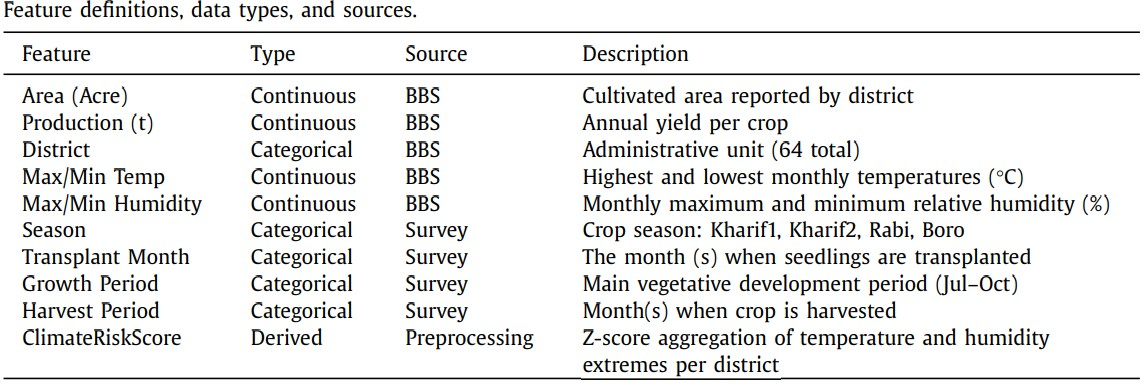

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf

In [ ]:
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from scipy.stats import skew, entropy
from sklearn.feature_selection import mutual_info_classif
from math import log2
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, top_k_accuracy_score, mean_squared_error, mean_absolute_error, accuracy_score, mutual_info_score
import xgboost as xgb
from tensorflow.keras import models, layers, callbacks

In [ ]:
import joblib

# Loading Data

In [ ]:
df = pd.read_csv('SPAS-Dataset-BD.csv')

# Preprocessing

## Data Exploration

In [ ]:
display(df.head())

,Area,AP Ratio,District,Season,Avg Temp,Avg Humidity,Crop Name,Transplant,Growth,Harvest,Production,Max Temp,Min Temp,Max Relative Humidity,Min Relative Humidity
0,177321,0.8510272331,Bagerhat,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,150905,40,12.0,60,85
1,25646,1.175777899,Bandarban,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,30154,40,12.0,60,85
2,231401,0.7705887183,Barguna,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,178315,40,12.0,60,85
3,302665,0.7571043893,Barishal,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,229149,40,12.0,60,85
4,388575,1.100652384,Bhola,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,427686,40,12.0,60,85


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Area                   4608 non-null   int64  
 1   AP Ratio               4608 non-null   object 
 2   District               4608 non-null   object 
 3   Season                 4607 non-null   object 
 4   Avg Temp               4608 non-null   float64
 5   Avg Humidity           4608 non-null   float64
 6   Crop Name              4608 non-null   object 
 7   Transplant             4608 non-null   object 
 8   Growth                 4608 non-null   object 
 9   Harvest                4608 non-null   object 
 10  Production             4608 non-null   int64  
 11  Max Temp               4608 non-null   int64  
 12  Min Temp               4608 non-null   float64
 13  Max Relative Humidity  4608 non-null   int64  
 14  Min Relative Humidity  4608 non-null   int64  
dtypes: f

In [ ]:
df['Harvest']

,Harvest
0,Nov to Dec
1,Nov to Dec
2,Nov to Dec
3,Nov to Dec
4,Nov to Dec
...,...
4603,August to September
4604,August to September
4605,August to September
4606,August to September


In [ ]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df['season'] = df['season'].str.strip().str.lower()
df['crop_name'] = df['crop_name'].str.strip().str.lower()

In [ ]:
months = ['january', 'february', 'march', 'april', 'may', 'june',
          'july', 'august', 'september', 'october', 'november', 'december']
month_to_idx = {m: i for i, m in enumerate(months)}
idx_to_month = {v: k for k, v in month_to_idx.items()}

month_abbr_map = {
    'jan': 'january', 'feb': 'february', 'mar': 'march', 'apr': 'april', 'may': 'may',
    'jun': 'june', 'jul': 'july', 'aug': 'august', 'sep': 'september',
    'oct': 'october', 'nov': 'november', 'dec': 'december'
}

In [ ]:
def clean_month_string(s):
    s = str(s).strip().lower()
    for abbr, full in month_abbr_map.items():
        s = re.sub(fr'\b{abbr}\b', full, s)
    return s

def month_range_to_vector(s):
    s = clean_month_string(s)
    split = re.split(r'\s+to\s+', s)
    vec = [0]*12
    if len(split) == 2:
        start, end = split
        if start in month_to_idx and end in month_to_idx:
            i1, i2 = month_to_idx[start], month_to_idx[end]
            if i1 <= i2:
                for i in range(i1, i2+1): vec[i] = 1
            else:
                for i in range(i1, 12): vec[i] = 1
                for i in range(0, i2+1): vec[i] = 1
    return vec

In [ ]:
growth_vectors = df['growth'].apply(month_range_to_vector).to_list()
harvest_vectors = df['harvest'].apply(month_range_to_vector).to_list()

growth_df = pd.DataFrame(growth_vectors, columns=[f'growth_{m[:3]}' for m in months])
harvest_df = pd.DataFrame(harvest_vectors, columns=[f'harvest_{m[:3]}' for m in months])

In [ ]:
df = pd.concat([df, growth_df, harvest_df], axis=1)
df.drop(columns=['growth', 'harvest'], inplace=True)

In [ ]:
def month_to_index(m):
    m = clean_month_string(m)
    return month_to_idx[m] if m in month_to_idx else np.nan

In [ ]:
df['transplant'] = df['transplant'].apply(clean_month_string)

In [ ]:
df['area'] = pd.to_numeric(df['area'], errors='coerce')
df['production'] = pd.to_numeric(df['production'], errors='coerce')
df['ap_ratio'] = df['area'] / df['production']
df['ap_ratio'] = df['ap_ratio'].astype(float)
df['area'] = df['area'].astype(int)
df['production'] = df['production'].astype(int)


In [ ]:
weather_cols = ['avg_temp', 'min_temp', 'max_temp', 'avg_humidity', 'min_relative_humidity', 'max_relative_humidity']
df[weather_cols] = df[weather_cols].apply(pd.to_numeric, errors='coerce')
# scaler = MinMaxScaler()
# df[weather_cols] = scaler.fit_transform(df[weather_cols])

In [ ]:
df['crop_name'].unique()

array(['aman', 'amra', 'arhar', 'aus', 'banana', 'barbati', 'beans',
       'betelnut', 'black berry', 'boro', 'boroi', 'cabbage', 'carrot',
       'cauliflower', 'chalkumra', 'cheena', 'chili', 'cucumber', 'dalim',
       'danta', 'danta shak', 'date palm', 'garlic', 'ginger', 'gourd',
       'gram', 'green coconut', 'green palmyra', 'green papaya',
       'groundnut', 'guava', 'jack fruit', 'jambura', 'jamrul', 'jhinga',
       'jute', 'kakrol', 'karala', 'kolmi shak', 'lady’s finger',
       'lal shak', 'laushak', 'lemon', 'lentil', 'maize 1', 'maize 2',
       'malta', 'mango', 'mashkalai', 'motor', 'mug', 'mukhi kachu',
       'oal kachu', 'onion', 'palmyra palm', 'palong shak', 'patal',
       'pineapple', 'puishak', 'pumpkin', 'radish', 'rape & mustard',
       'ripe papaya', 'safeda', 'sesame', 'shalgom', 'sugarcane',
       'sweet potato', 'taramind', '#ref!', 'tobacco', 'wheat',
       'wood apple'], dtype=object)

## Encoding

In [ ]:
df = df[df['crop_name'] != '#ref!']

In [ ]:
df = df[df['season'].notna()].copy()


In [ ]:
le_crop = LabelEncoder()
df['crop_name_enc'] = le_crop.fit_transform(df['crop_name'])

le_season = LabelEncoder()
df['season_enc'] = le_season.fit_transform(df['season'])

le_district = LabelEncoder()
df['district_enc'] = le_district.fit_transform(df['district'])

df['transplant_month'] = df['transplant'].apply(lambda x : month_to_idx[x])



df.drop(columns=['crop_name', 'season', 'district', 'transplant'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4606 entries, 0 to 4607
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   4606 non-null   int64  
 1   ap_ratio               4197 non-null   float64
 2   avg_temp               4606 non-null   float64
 3   avg_humidity           4606 non-null   float64
 4   production             4606 non-null   int64  
 5   max_temp               4606 non-null   int64  
 6   min_temp               4606 non-null   float64
 7   max_relative_humidity  4606 non-null   int64  
 8   min_relative_humidity  4606 non-null   int64  
 9   growth_jan             4606 non-null   int64  
 10  growth_feb             4606 non-null   int64  
 11  growth_mar             4606 non-null   int64  
 12  growth_apr             4606 non-null   int64  
 13  growth_may             4606 non-null   int64  
 14  growth_jun             4606 non-null   int64  
 15  growth_ju

In [ ]:
df.head()

,area,ap_ratio,avg_temp,avg_humidity,production,max_temp,min_temp,max_relative_humidity,min_relative_humidity,growth_jan,growth_feb,growth_mar,growth_apr,growth_may,growth_jun,growth_jul,growth_aug,growth_sep,growth_oct,growth_nov,growth_dec,harvest_jan,harvest_feb,harvest_mar,harvest_apr,harvest_may,harvest_jun,harvest_jul,harvest_aug,harvest_sep,harvest_oct,harvest_nov,harvest_dec,crop_name_enc,season_enc,district_enc,transplant_month
0,177321,1.175051,26.0,72.5,150905,40,12.0,60,85,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,5
1,25646,0.850501,26.0,72.5,30154,40,12.0,60,85,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,5
2,231401,1.297709,26.0,72.5,178315,40,12.0,60,85,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,5
3,302665,1.320822,26.0,72.5,229149,40,12.0,60,85,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,3,5
4,388575,0.908552,26.0,72.5,427686,40,12.0,60,85,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,4,5


Essential function to preprocess the inputs coming from web end in order to feed the model...

## Exploratory Data Analysis (EDA)

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 6)

In [ ]:
top_crops = df['crop_name_enc'].value_counts().head(15)

In [ ]:
df_valid = df.copy()
df_valid = df_valid[(df_valid['production'] > 0) & (df_valid['area'] > 0)]
df_valid['ap_ratio'] = df_valid['area'] / df_valid['production']
df_valid = df_valid.dropna(subset=['district_enc', 'crop_name_enc', 'ap_ratio'])
df_valid = df_valid[df_valid['crop_name_enc'] != 0]


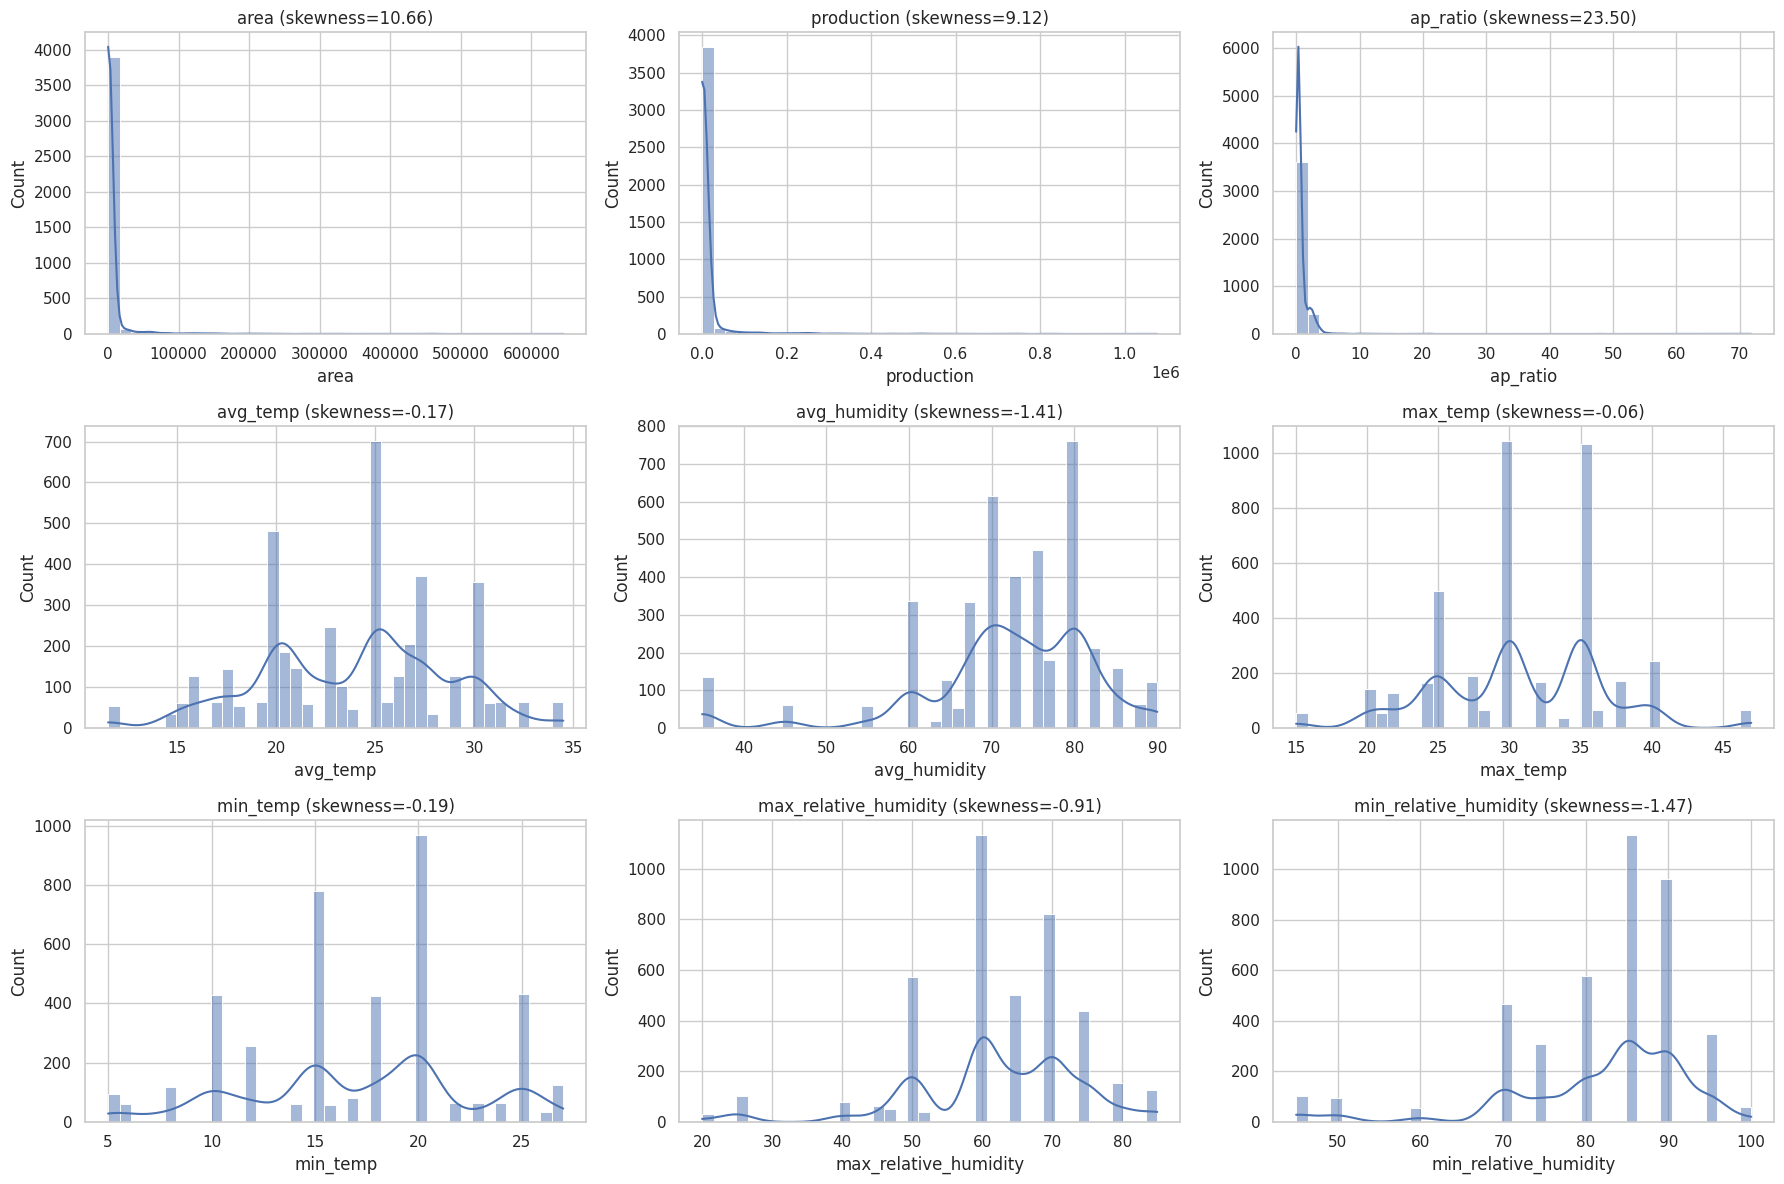

In [ ]:
num_cols = ['area', 'production', 'ap_ratio', 'avg_temp', 'avg_humidity',
            'max_temp', 'min_temp', 'max_relative_humidity', 'min_relative_humidity']

plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_valid[col], kde=True, bins=40)
    plt.title(f'{col} (skewness={skew(df_valid[col].dropna()):.2f})')
plt.tight_layout()
plt.show()


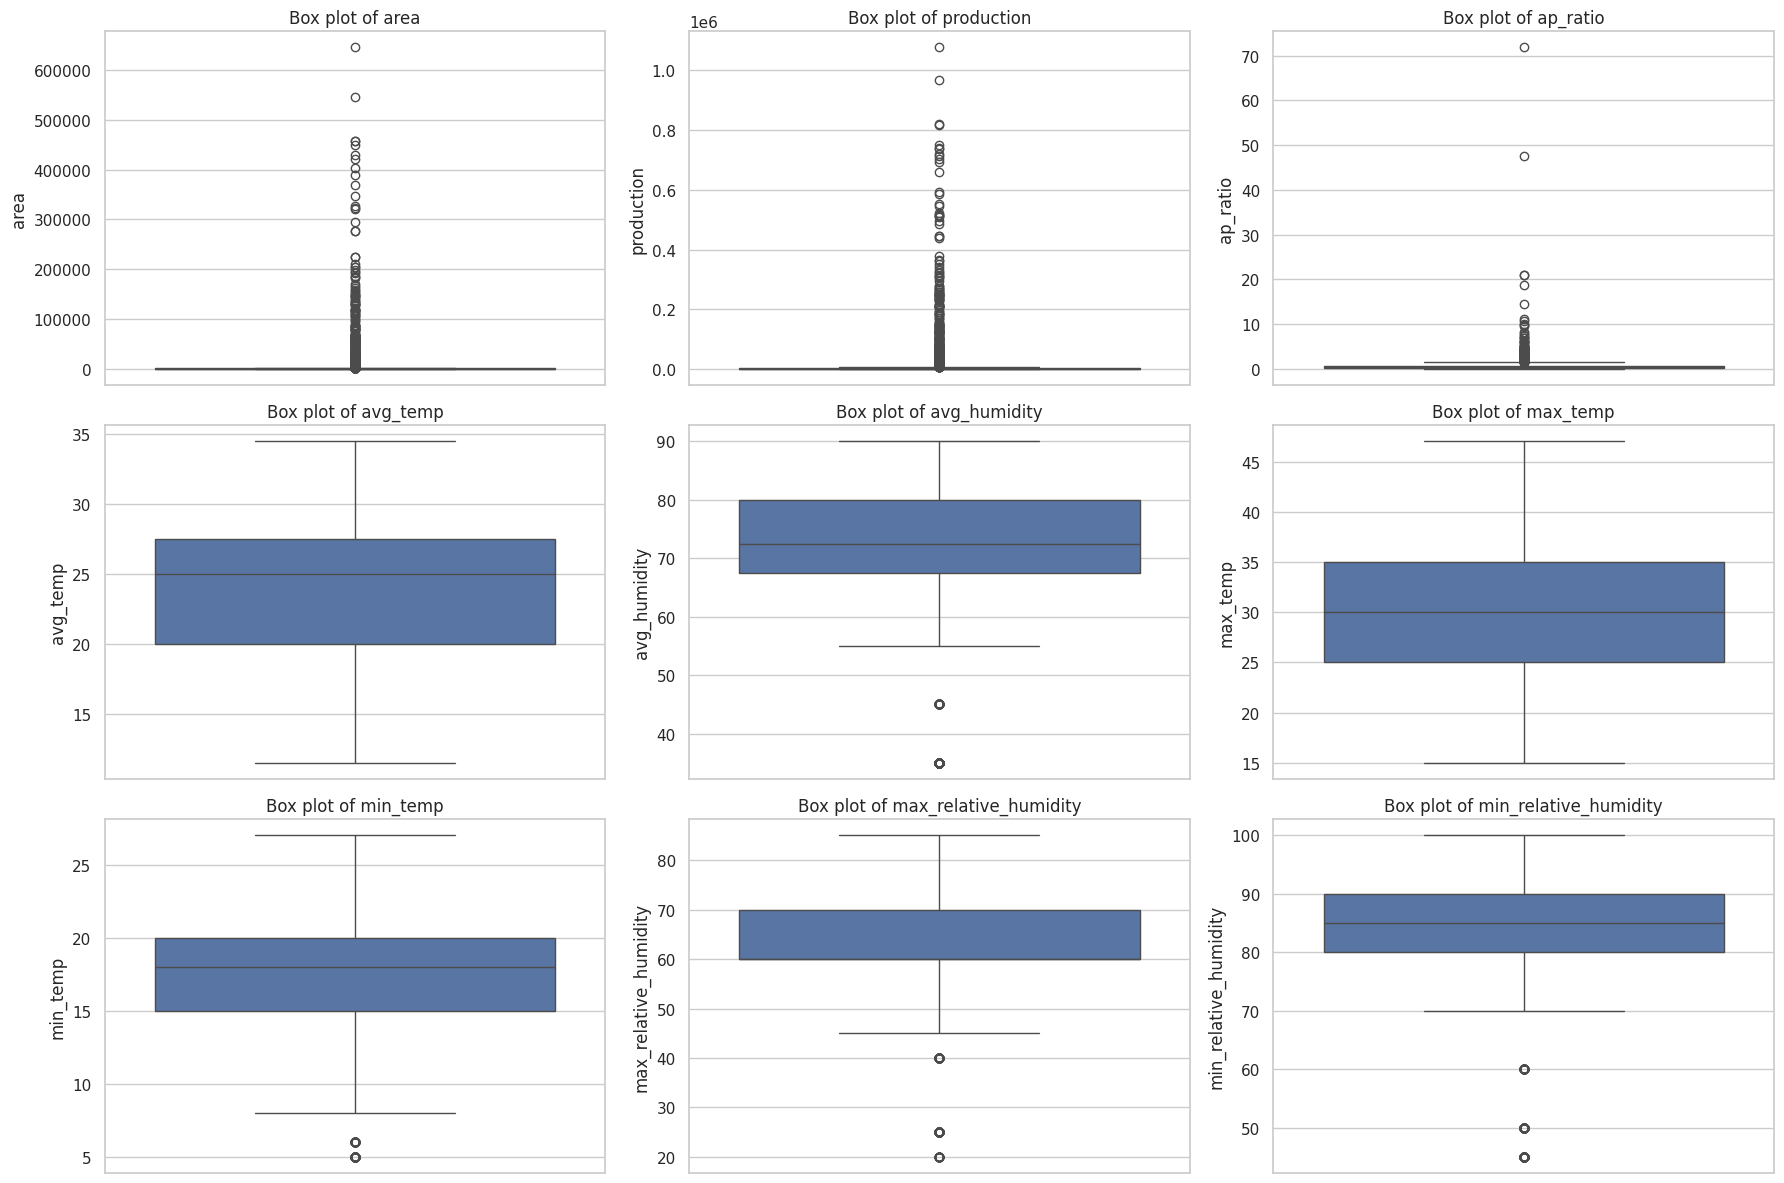

In [ ]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_valid[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

Insight: Based on the box plot of the 'area' column, it appears there are many outliers with significantly larger values than the majority of the data. This is indicated by the numerous points extending far above the upper whisker of the box plot.

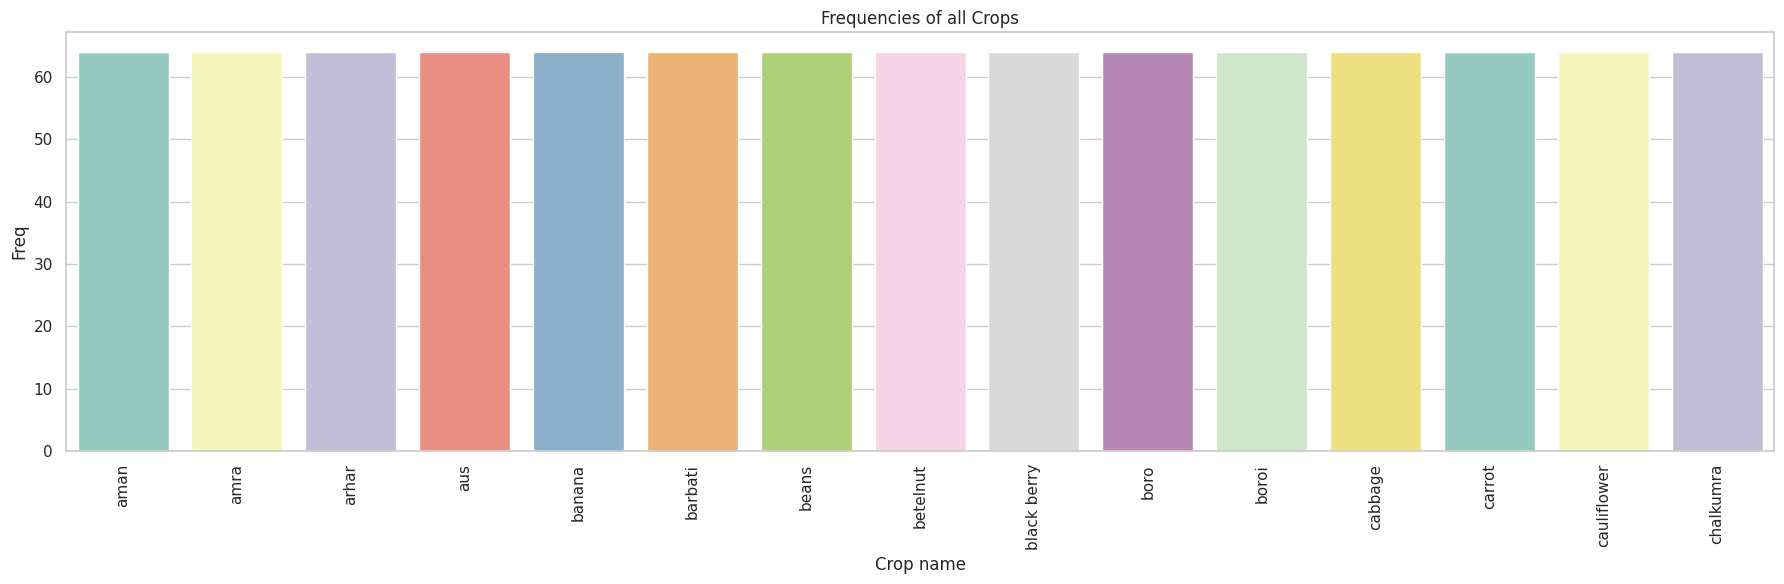

In [ ]:
top_crops.index = le_crop.inverse_transform(top_crops.index)
sns.barplot(x=top_crops.index, y=top_crops.values, palette='Set3', hue=top_crops.index, legend=False)
plt.title("Frequencies of all Crops")
plt.xlabel("Crop name")
plt.ylabel("Freq")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Insight: I found that all the crops are appeared in equal frequencies.

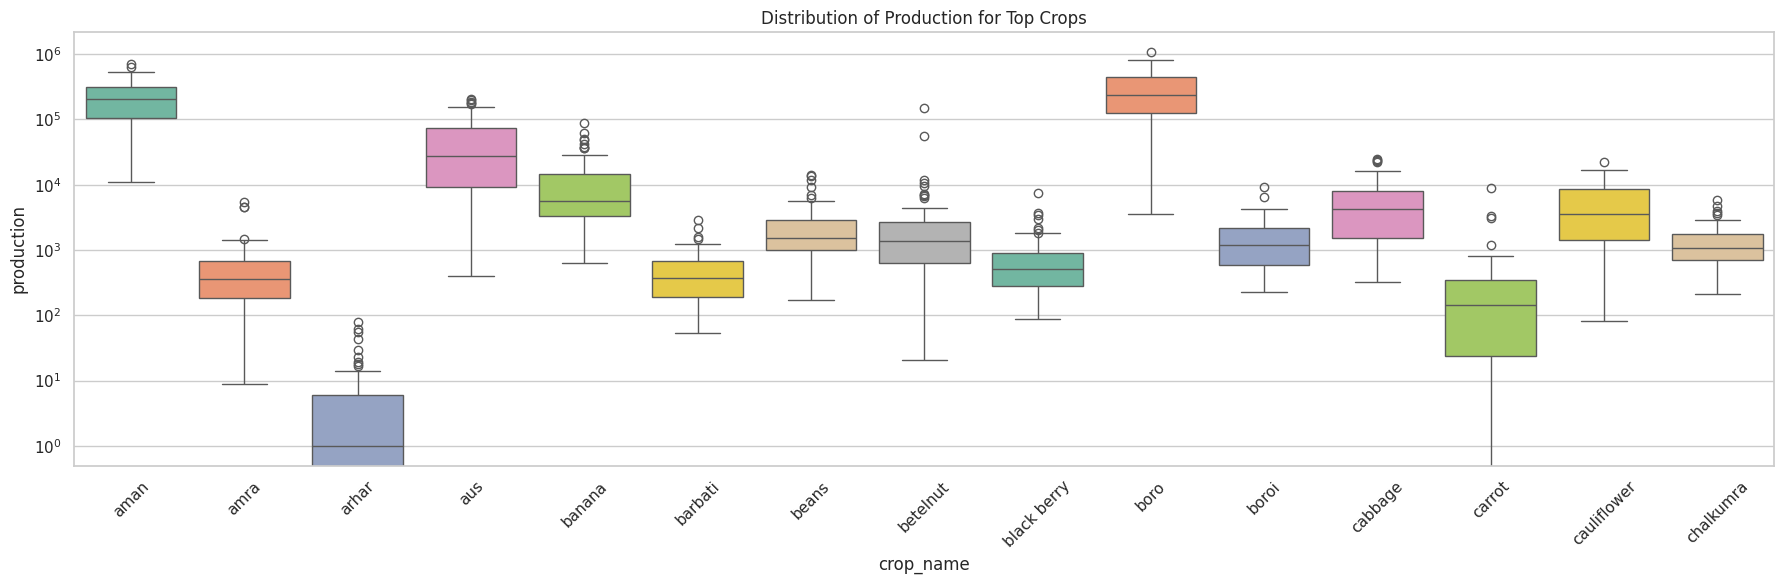

In [ ]:
top_crop_names = top_crops.index.tolist()
filtered_df = df[df['crop_name_enc'].isin(le_crop.transform(top_crop_names))].copy() # Explicitly create a copy
filtered_df['crop_name'] = le_crop.inverse_transform(filtered_df['crop_name_enc'])

sns.boxplot(data=filtered_df, x='crop_name', y='production', hue='crop_name', palette='Set2', legend=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Distribution of Production for Top Crops")
plt.tight_layout()
plt.show()

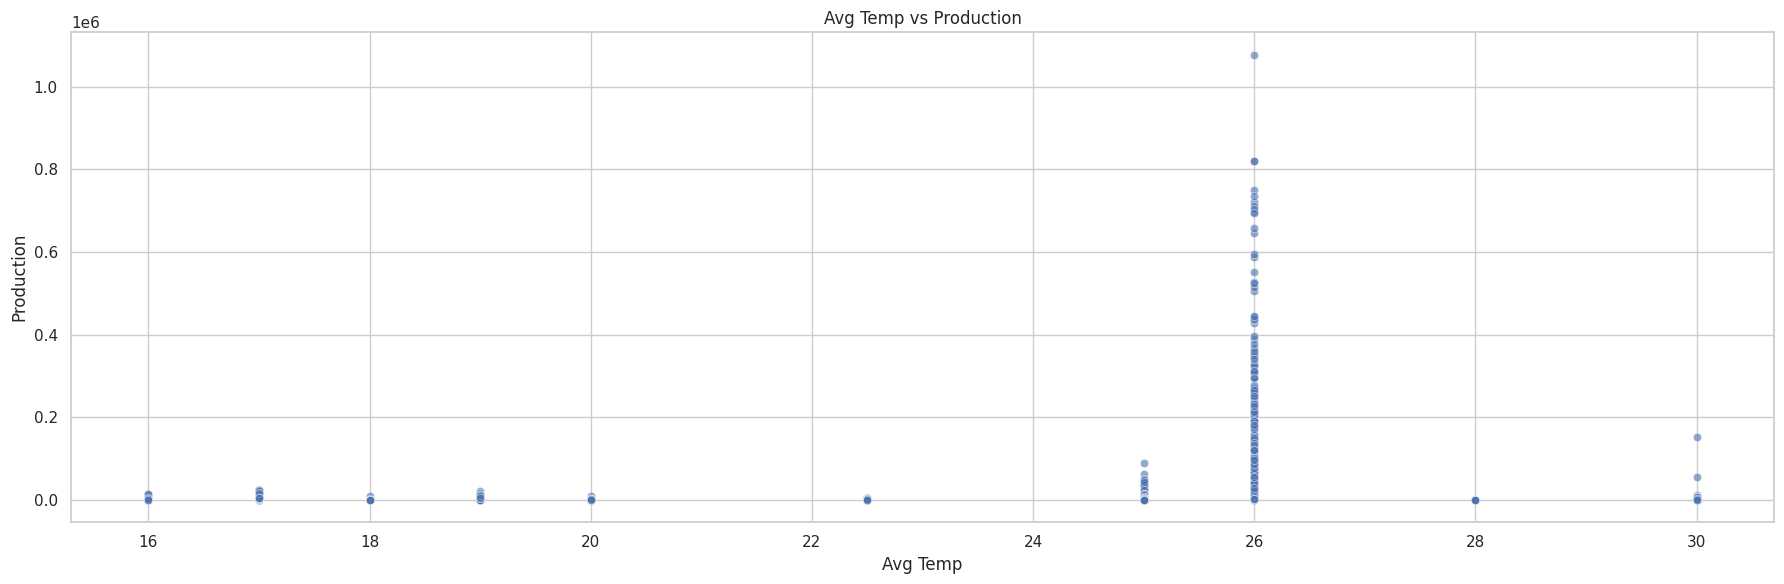

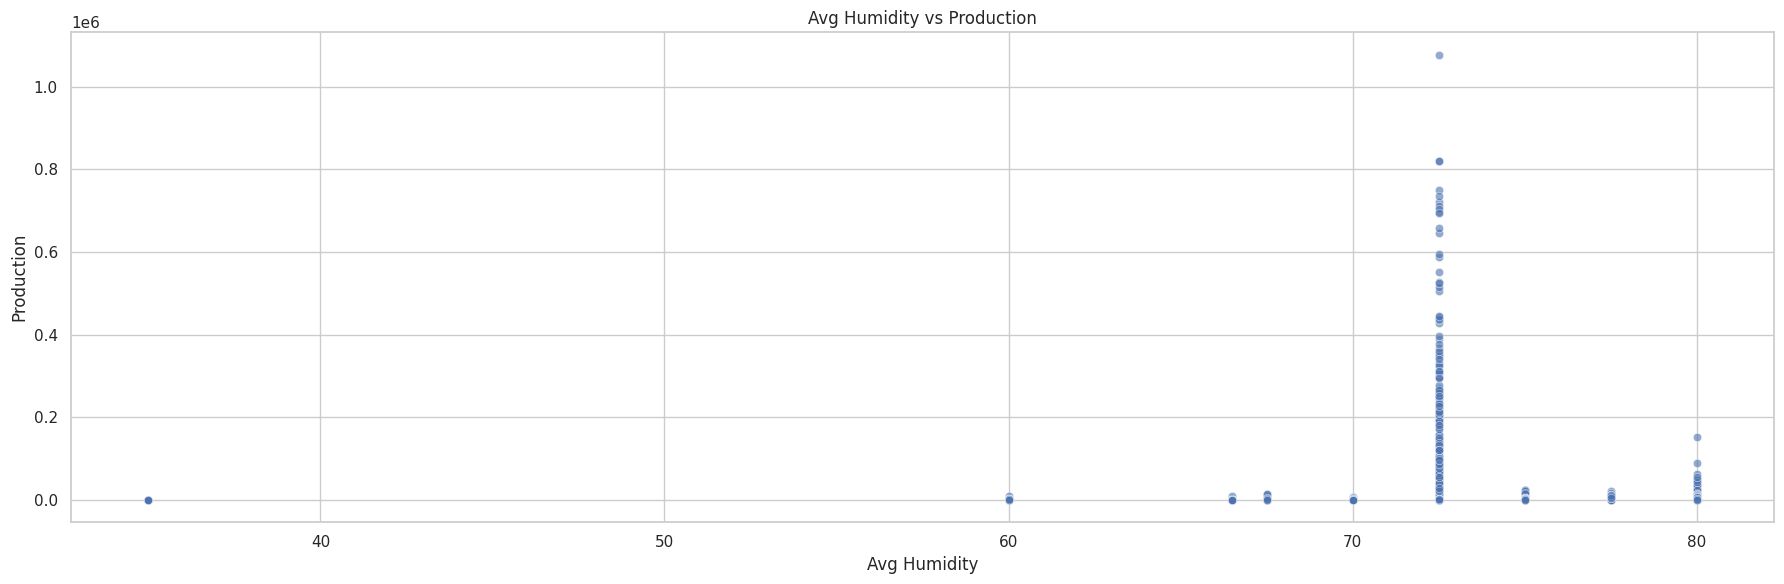

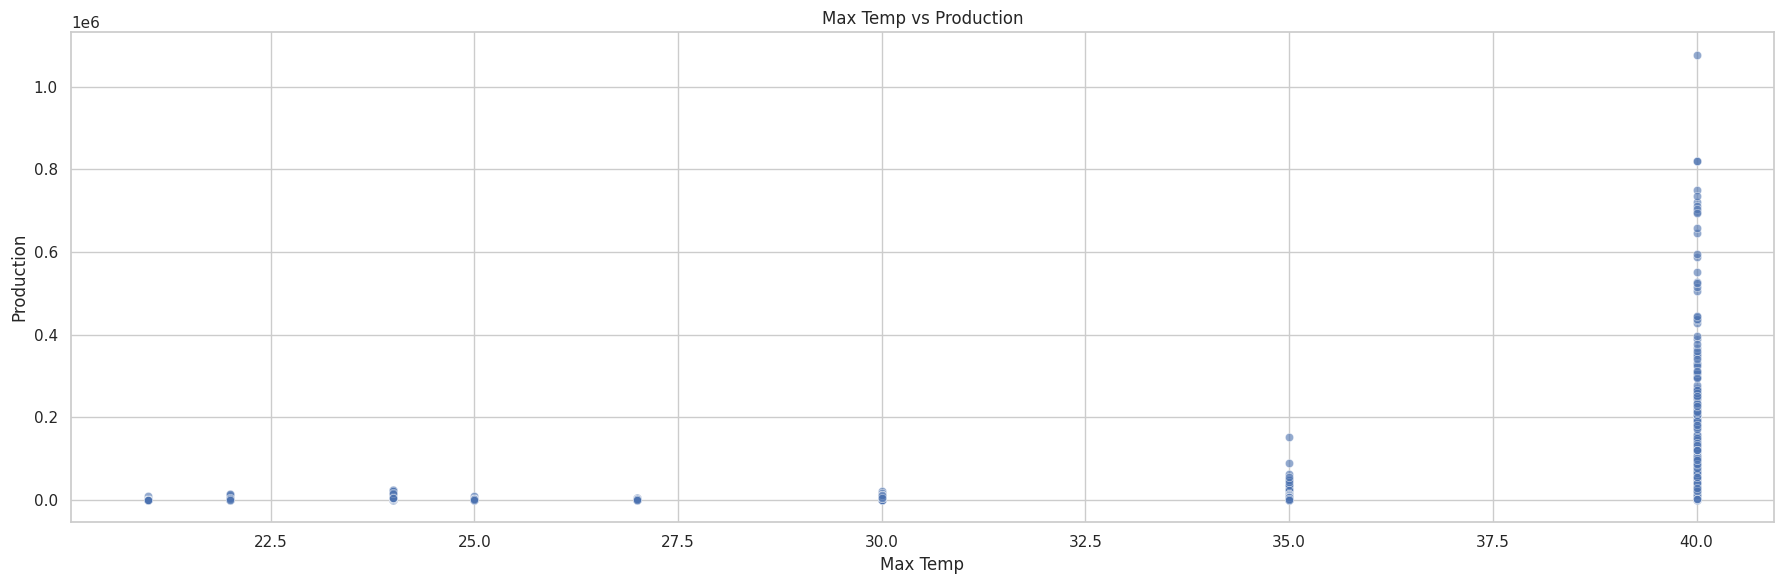

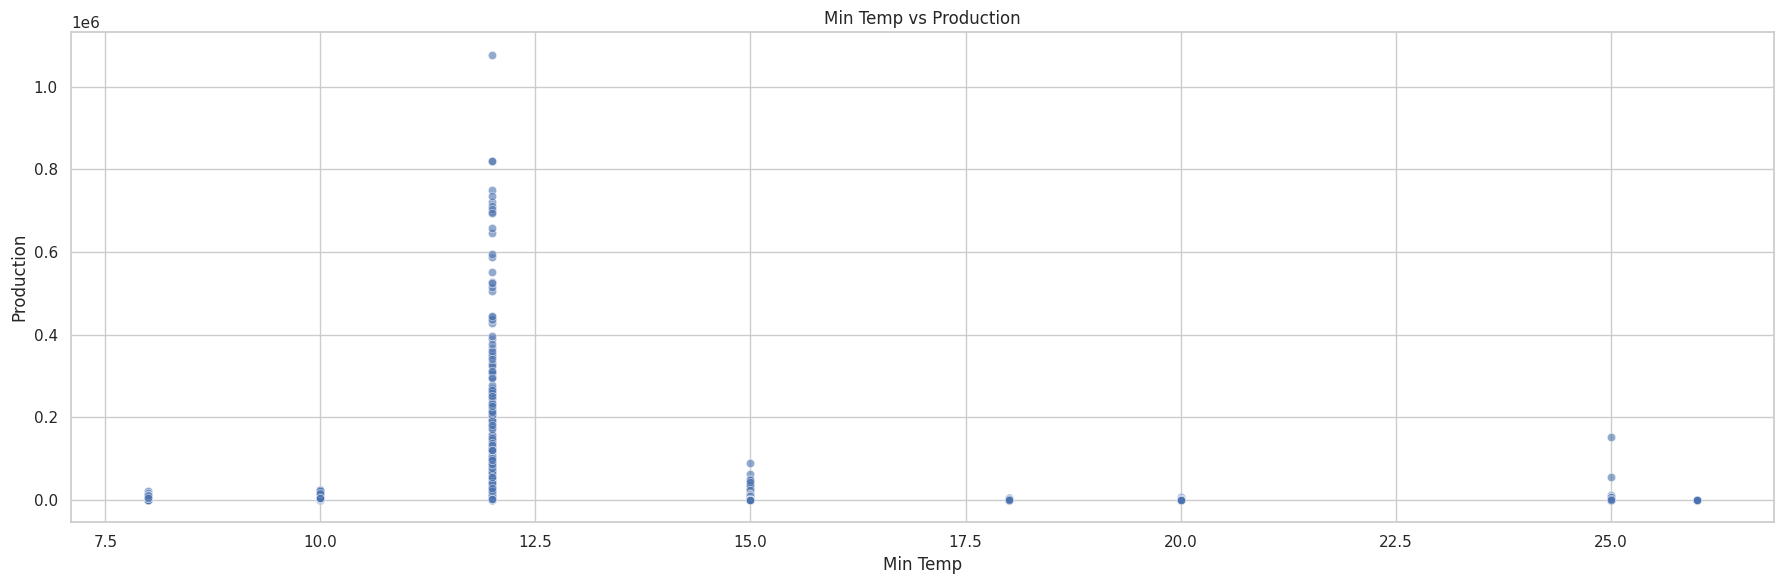

In [ ]:
climate_vars = ['avg_temp', 'avg_humidity', 'max_temp', 'min_temp']

for var in climate_vars:
    sns.scatterplot(data=filtered_df, x=var, y='production', alpha=0.6)
    plt.title(f"{var.replace('_', ' ').title()} vs Production")
    plt.ylabel("Production")
    plt.xlabel(var.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()


Insight: The scatter plots of climate variables against production don't show strong linear correlations. This suggests that the relationship between individual climate factors and production might be complex or influenced by other variables, or that these variables alone are not the primary drivers of production across all top crops.

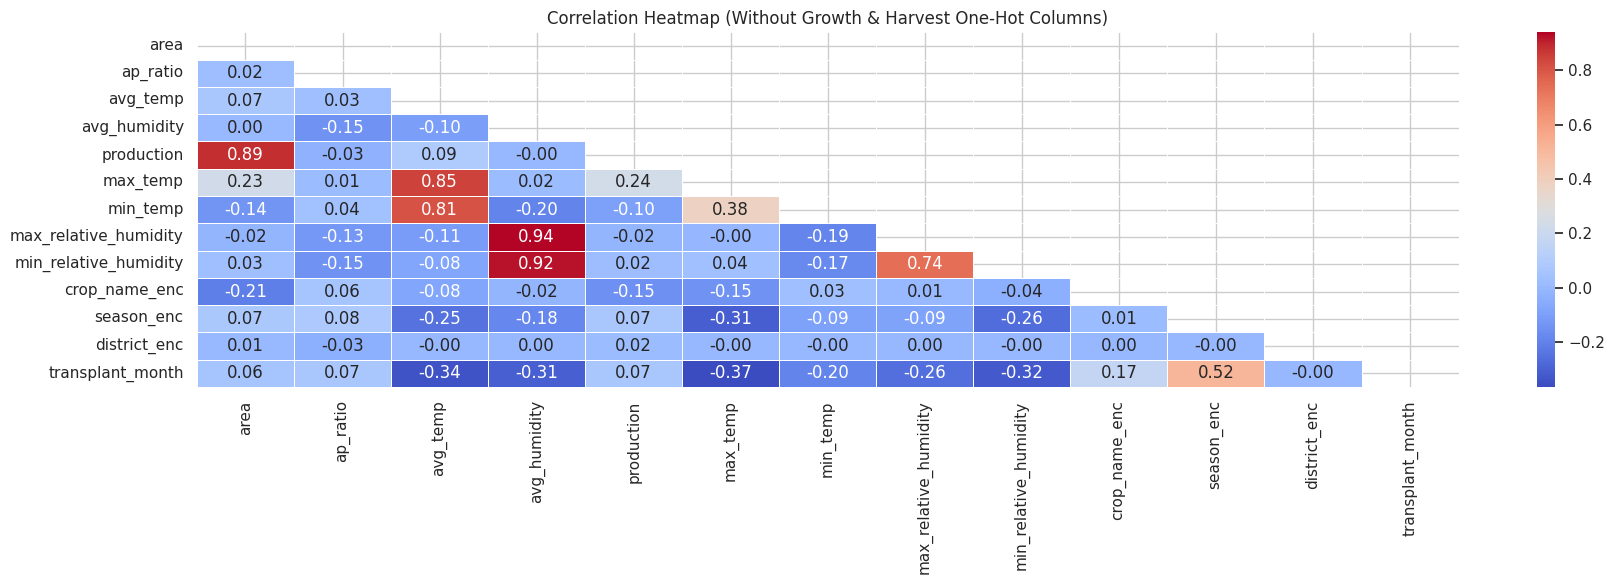

In [ ]:
cols_to_exclude = [col for col in df.columns if col.startswith('growth_') or col.startswith('harvest_')]
corr_df = df.drop(columns=cols_to_exclude)
corr = corr_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap (Without Growth & Harvest One-Hot Columns)")
plt.tight_layout()
plt.show()

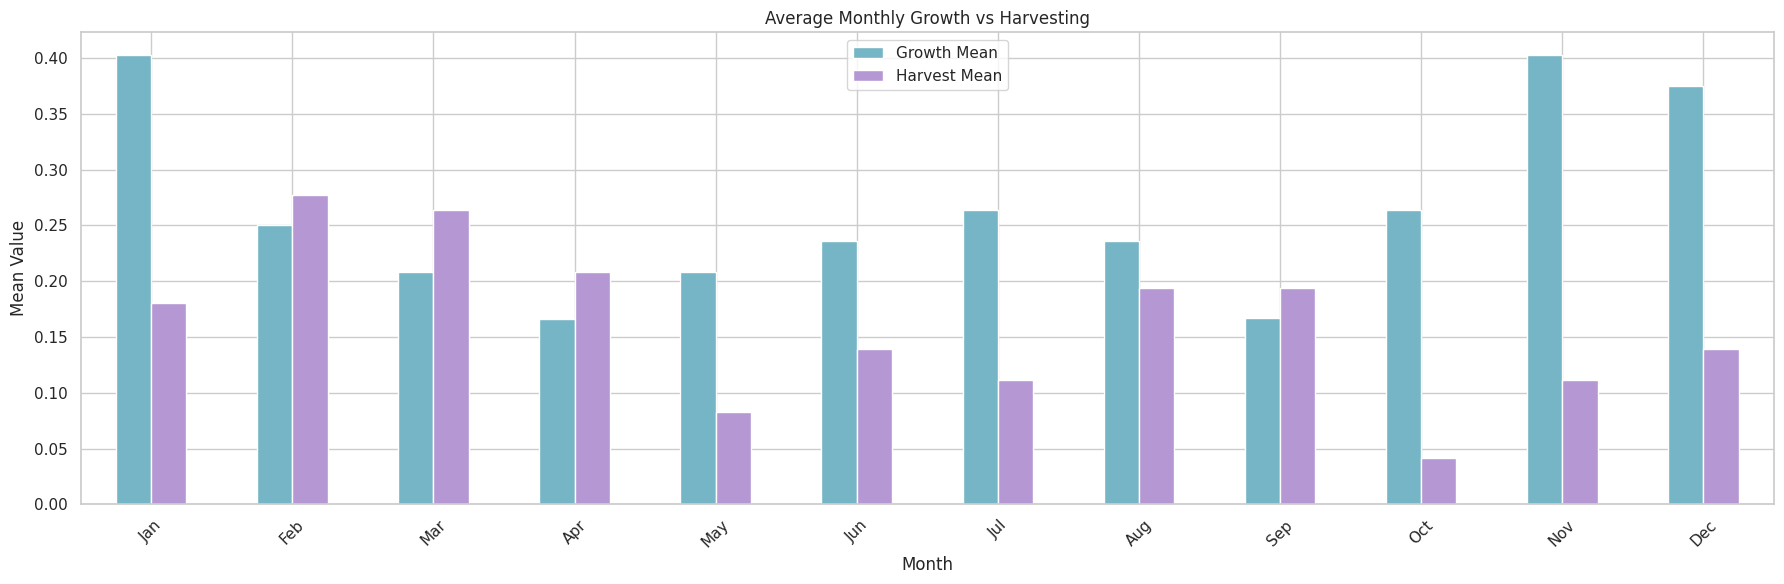

In [ ]:
growth_cols = [col for col in df.columns if 'growth_' in col]
harvest_cols = [col for col in df.columns if 'harvest_' in col]

monthly_df = pd.DataFrame({
    "Month": [col.split('_')[1].title() for col in growth_cols],
    "Growth Mean": df[growth_cols].mean().values,
    "Harvest Mean": df[harvest_cols].mean().values
})

monthly_df = monthly_df.set_index("Month")

monthly_df.plot(kind='bar', color=['#76b5c5', '#b597d3'])
plt.title("Average Monthly Growth vs Harvesting")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Insight: The bar plot of average monthly growth vs harvesting shows the distribution of these activities throughout the year. We can see that growth activity is higher in the earlier months, while harvesting activity peaks in certain periods depending on the crop. This highlights the importance of considering seasonal patterns in crop production.

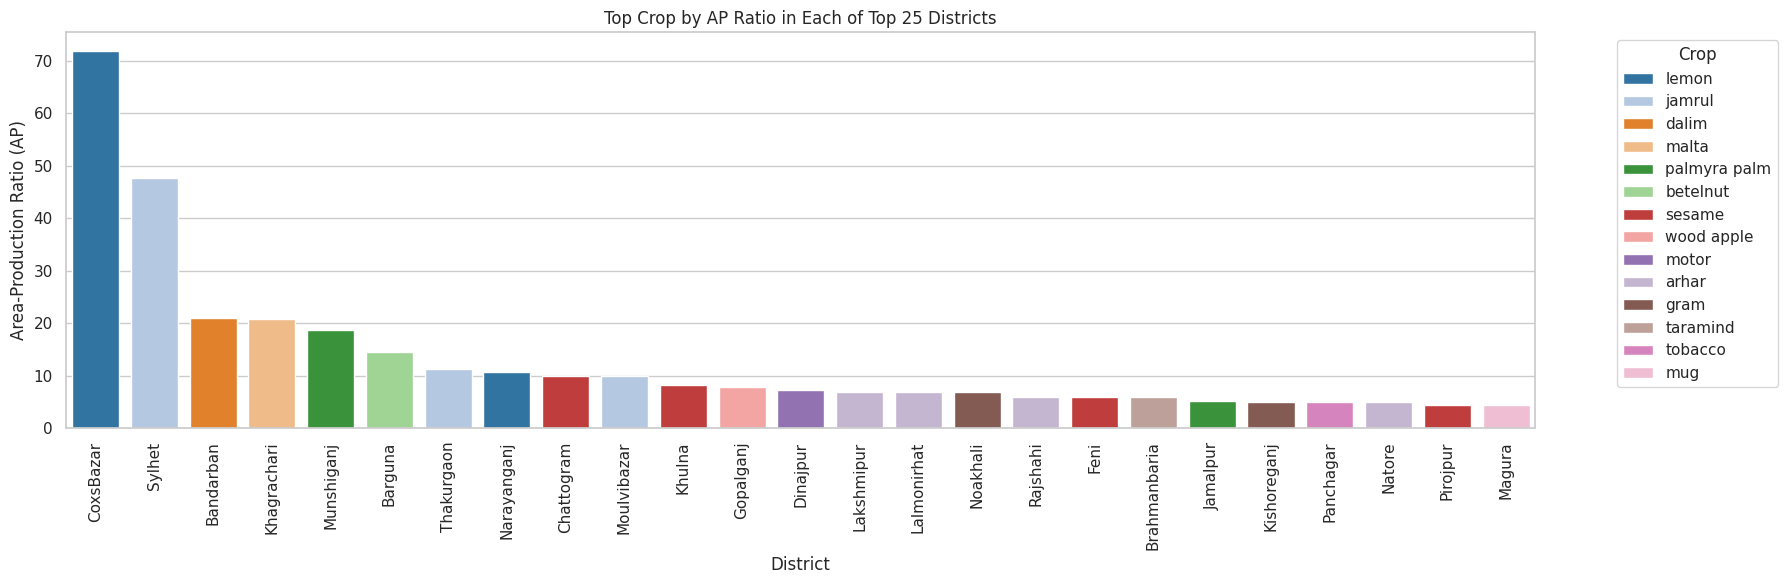

In [ ]:
idx = df_valid.groupby('district_enc')['ap_ratio'].idxmax()
top_district_crops = df_valid.loc[idx, ['district_enc', 'crop_name_enc', 'ap_ratio']]

top_district_crops['crop_name'] = le_crop.inverse_transform(top_district_crops['crop_name_enc'].astype(int))
top_district_crops['district_name'] = le_district.inverse_transform(top_district_crops['district_enc'].astype(int))

top_district_crops = top_district_crops.sort_values(by='ap_ratio', ascending=False).head(25)

sns.barplot(x='district_name', y='ap_ratio', hue='crop_name', dodge=False, data=top_district_crops, palette='tab20')
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('Area-Production Ratio (AP)')
plt.title('Top Crop by AP Ratio in Each of Top 25 Districts')
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

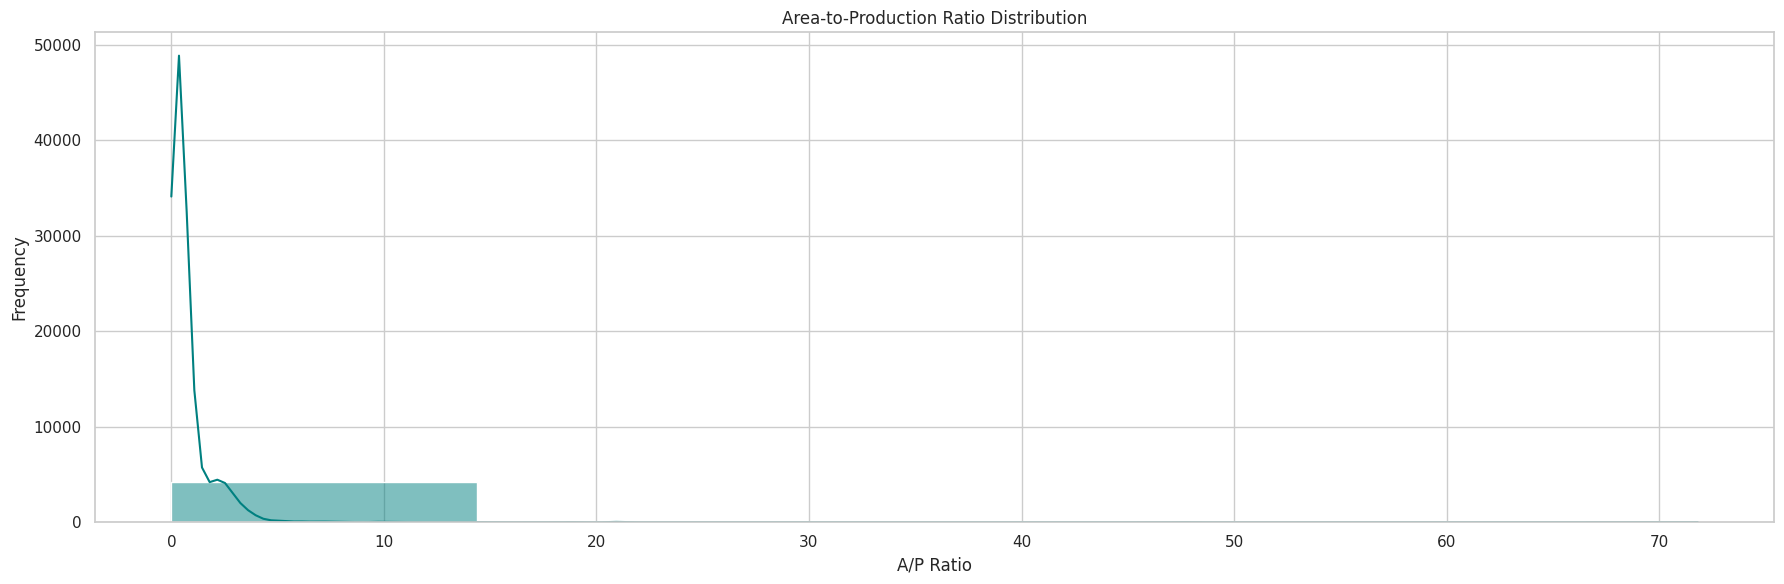

In [ ]:
sns.histplot(df['ap_ratio'].dropna(), bins=5, kde=True, color='teal')
plt.title("Area-to-Production Ratio Distribution")
plt.xlabel("A/P Ratio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


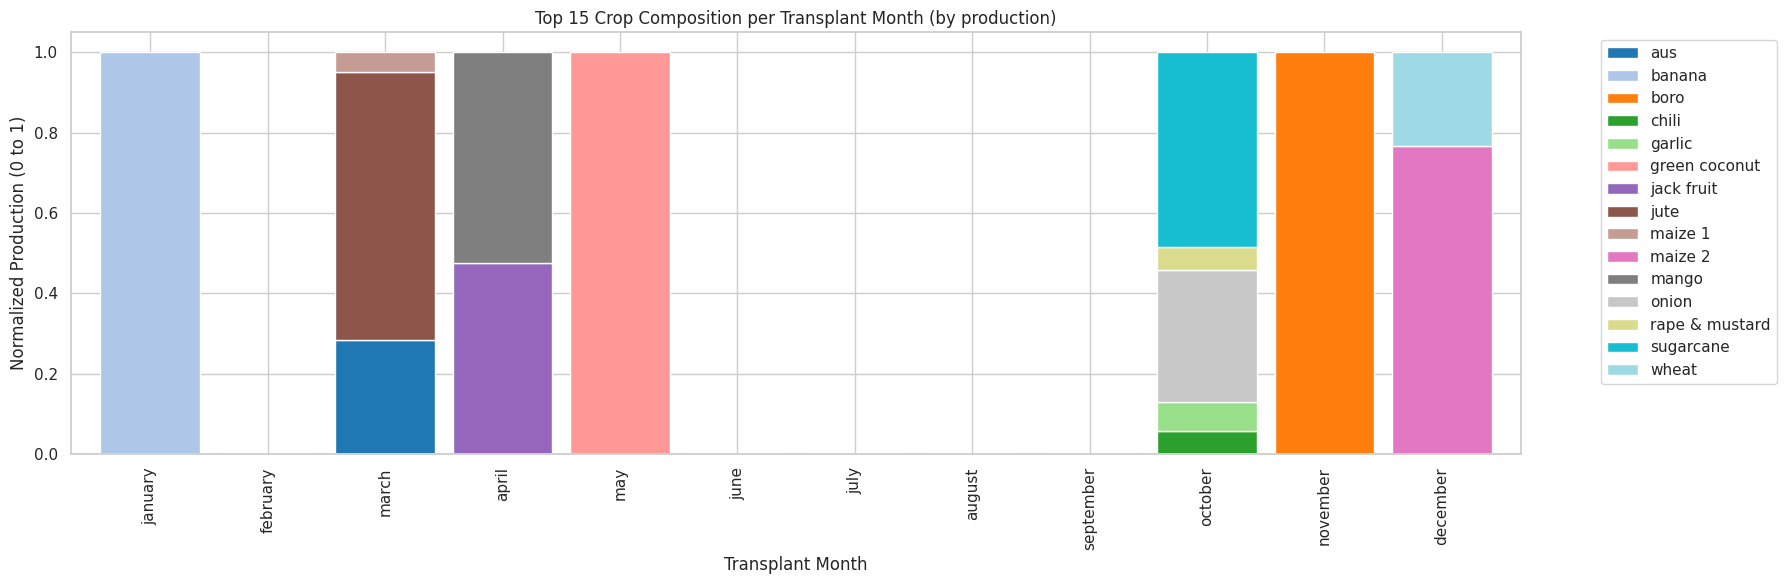

In [ ]:
df_trans = df_valid.copy()

# Decode crop and transplant month
df_trans['crop_name'] = le_crop.inverse_transform(df_trans['crop_name_enc'].astype(int))
df_trans['transplant_month'] = df_trans['transplant_month'].apply(lambda x : idx_to_month[x])

# Ensure chronological order of months
month_order = ['january','february','march','april','may','june','july',
               'august','september','october','november','december']

df_trans['transplant_month'] = pd.Categorical(
    df_trans['transplant_month'], categories=month_order, ordered=True
)

# Sort by month order
df_trans = df_trans.sort_values(by='transplant_month').reset_index(drop=True)

# Select top 15 crops
top_crops = df_trans.groupby('crop_name')['production'].sum().nlargest(15).index
df_trans = df_trans[df_trans['crop_name'].isin(top_crops)]

# Pivot and normalize within each month
pivot = df_trans.pivot_table(
    index='transplant_month',
    columns='crop_name',
    values='production',
    aggfunc='sum',
    observed=False
).fillna(0)

pivot = pivot.apply(lambda x: x / x.sum(), axis=1)

# Plot chronologically
pivot.loc[month_order].plot(kind='bar', stacked=True, colormap='tab20', width=0.85)

plt.title('Top 15 Crop Composition per Transplant Month (by production)')
plt.xlabel('Transplant Month')
plt.ylabel('Normalized Production (0 to 1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Insight: The stacked bar chart of the top 15 crop composition per transplant month highlights the seasonal nature of crop transplantation. Different crops have distinct transplanting periods, and the chart clearly shows which crops are predominantly transplanted in which months, based on their contribution to the total normalized production for that month.

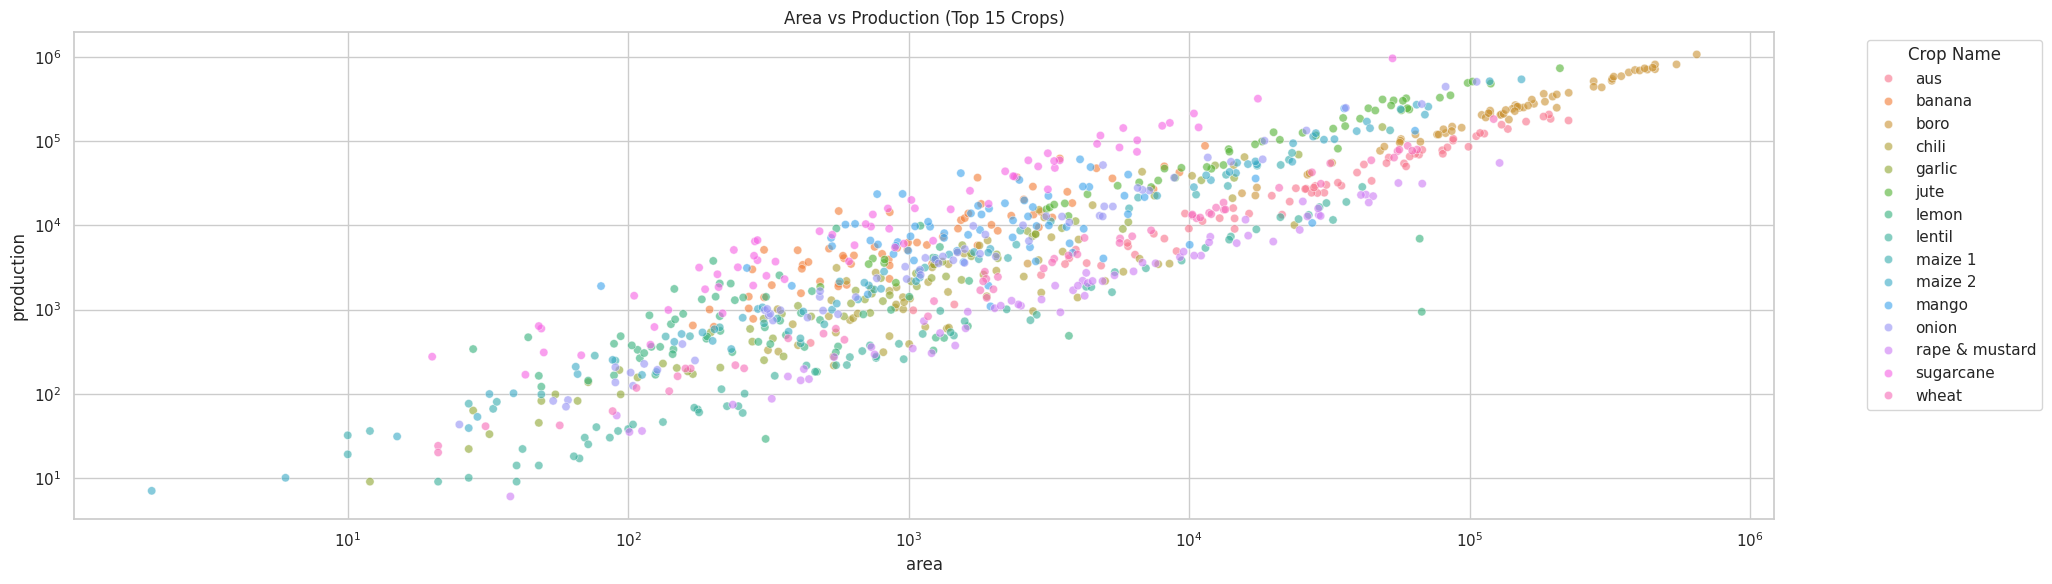

In [ ]:
df_valid['crop_name'] = le_crop.inverse_transform(df_valid['crop_name_enc'].astype(int))

top_crops = df_valid.groupby('crop_name')['area'].sum().nlargest(15).index
df_top = df_valid[df_valid['crop_name'].isin(top_crops)]

sns.scatterplot(data=df_top, x='area', y='production', hue='crop_name', alpha=0.6)
plt.title('Area vs Production (Top 15 Crops)')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.legend(title='Crop Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Insight: The scatter plot of Area vs Production for the top 15 crops, with both axes on a log scale, reveals the relationship between the land area used and the resulting production. The spread of points for each crop can indicate the variability in production efficiency across different areas.

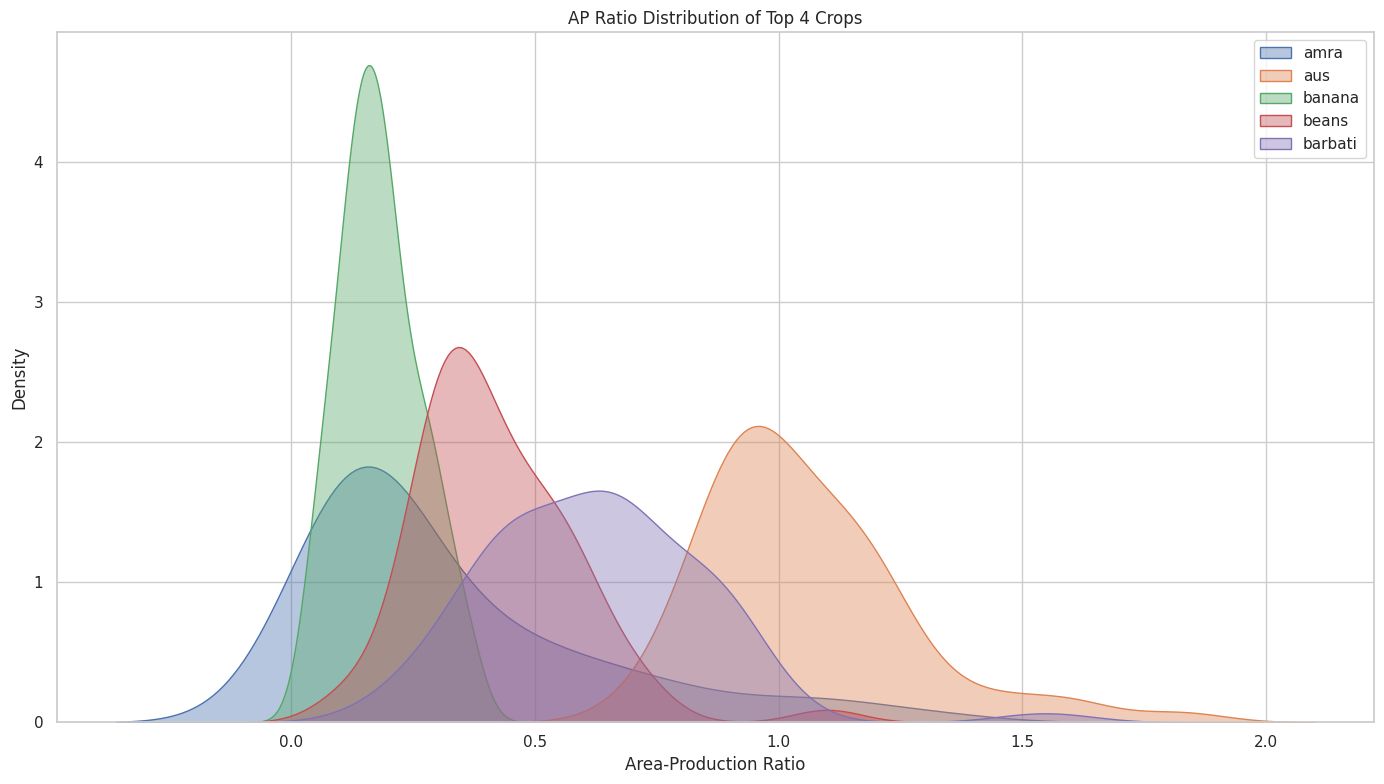

In [ ]:
plt.figure(figsize=(14, 8))
for crop_enc in df_valid['crop_name_enc'].value_counts().head(5).index:
    crop_name = le_crop.inverse_transform([crop_enc])[0]
    sns.kdeplot(df_valid[df_valid['crop_name_enc'] == crop_enc]['ap_ratio'], label=crop_name, fill=True, alpha=0.4)
plt.title('AP Ratio Distribution of Top 4 Crops')
plt.xlabel('Area-Production Ratio')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


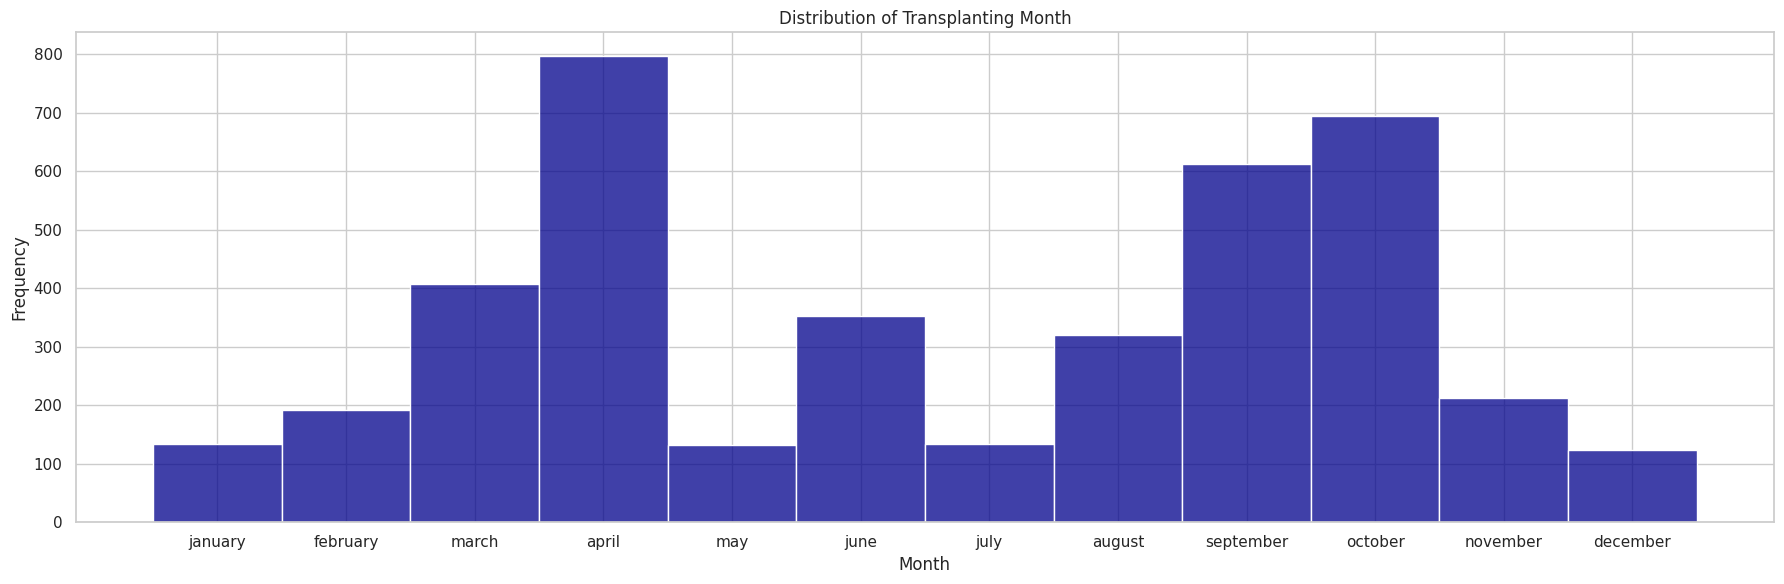

In [ ]:
trans_months = df_valid['transplant_month'].apply(lambda x : idx_to_month[x])
month_order = ['january','february','march','april','may','june','july',
               'august','september','october','november','december']
trans_months = pd.Categorical(
    trans_months, categories=month_order, ordered=True
)

sns.histplot(trans_months, bins=12, kde=False, color='darkblue')
plt.title("Distribution of Transplanting Month")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2752364938.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_crops_prod.index, y=top_crops_prod.values, palette='Set2')


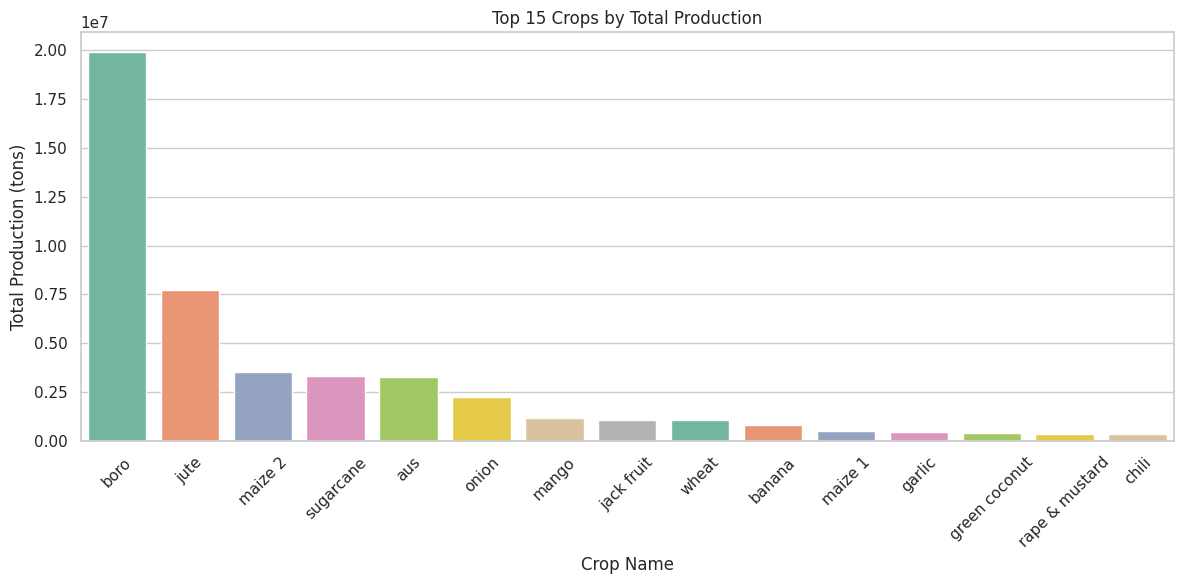

In [ ]:
top_crops_prod = df_valid.groupby('crop_name_enc')['production'].sum().nlargest(15)
top_crops_prod.index = le_crop.inverse_transform(top_crops_prod.index)

plt.figure(figsize=(12,6))
sns.barplot(x=top_crops_prod.index, y=top_crops_prod.values, palette='Set2')
plt.title("Top 15 Crops by Total Production")
plt.xlabel("Crop Name")
plt.ylabel("Total Production (tons)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


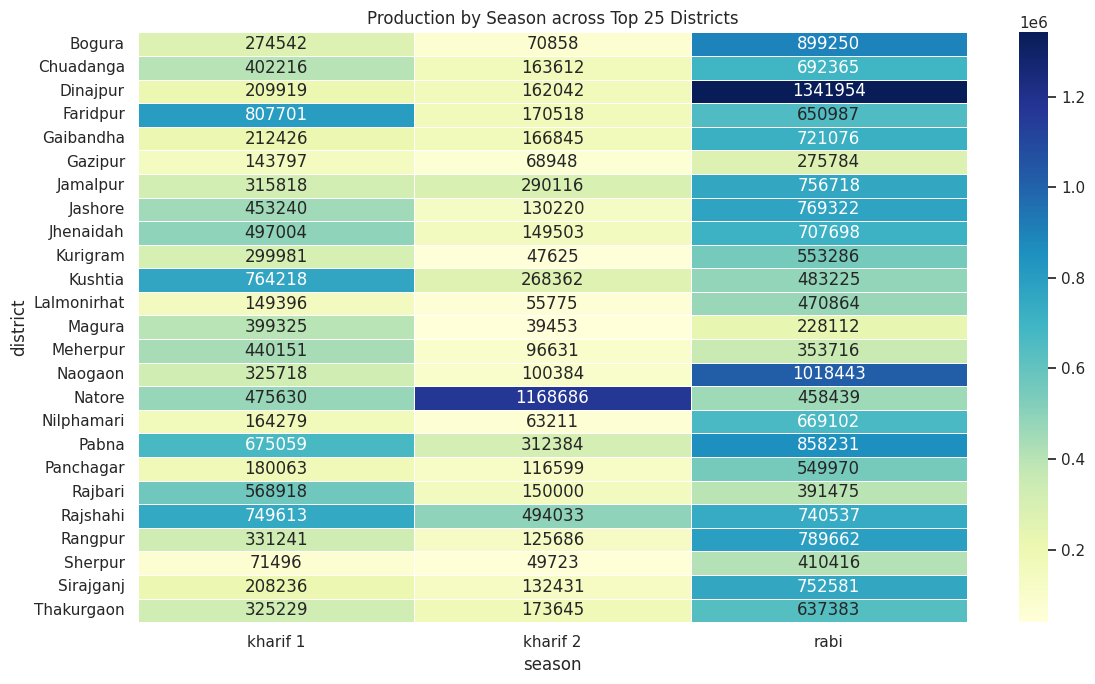

In [ ]:
top_districts = df_valid['district_enc'].value_counts().head(25).index
heat_data = df_valid[df_valid['district_enc'].isin(top_districts)].copy() # Explicitly create a copy
heat_data['district'] = le_district.inverse_transform(heat_data['district_enc'])
heat_data['season'] = le_season.inverse_transform(heat_data['season_enc'])

pivot = heat_data.pivot_table(index='district', columns='season', values='production', aggfunc='sum').fillna(0)

plt.figure(figsize=(12, 7))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)
plt.title("Production by Season across Top 25 Districts")
plt.tight_layout()
plt.show()

In [ ]:
top_crops = df_trans.groupby('crop_name')['production'].sum().nlargest(15).index

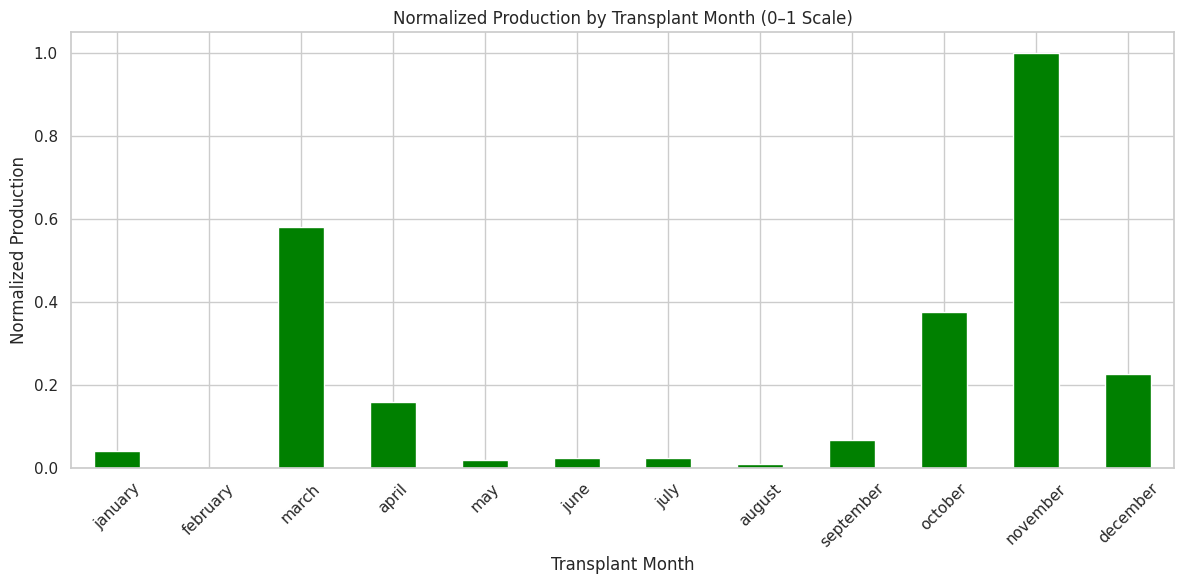

In [ ]:
monthly_prod = (
    df_valid.groupby('transplant_month')['production']
    .sum()
)

# Convert month index to names
monthly_prod.index = [idx_to_month[i] for i in monthly_prod.index]

# Normalize to [0, 1]
monthly_prod = (monthly_prod - monthly_prod.min()) / (monthly_prod.max() - monthly_prod.min())

# Plot normalized values
monthly_prod.plot(kind='bar', figsize=(12,6), color='green')
plt.title('Normalized Production by Transplant Month (0–1 Scale)')
plt.ylabel('Normalized Production')
plt.xlabel('Transplant Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


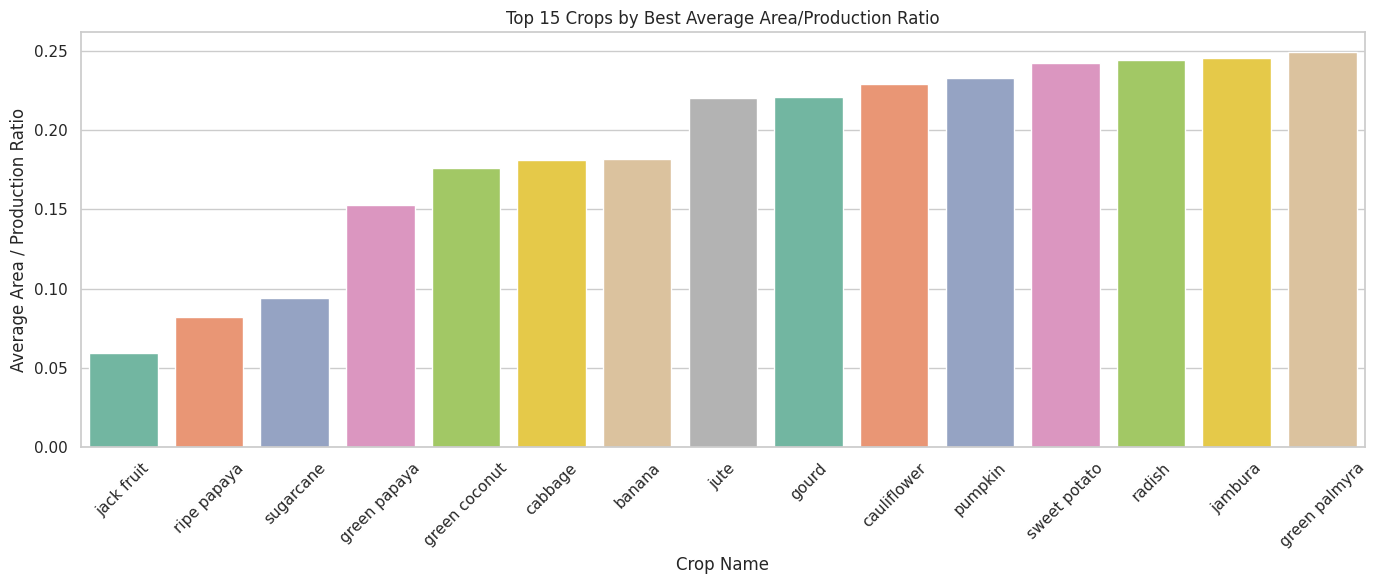

In [ ]:
df_valid = df_valid[df_valid['ap_ratio'].notna() & (df_valid['ap_ratio'] > 0)].copy() # Added .copy() to avoid SettingWithCopyWarning

# Decode crop_name_enc back to crop_name for plotting
df_valid['crop_name'] = le_crop.inverse_transform(df_valid['crop_name_enc'].astype(int))

crop_eff = df_valid.groupby('crop_name')['ap_ratio'].mean().sort_values()

plt.figure(figsize=(14,6))
sns.barplot(x=crop_eff.index[:15], y=crop_eff.values[:15], hue=crop_eff.index[:15], palette='Set2', legend=False)
plt.title('Top 15 Crops by Best Average Area/Production Ratio')
plt.ylabel('Average Area / Production Ratio')
plt.xlabel('Crop Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

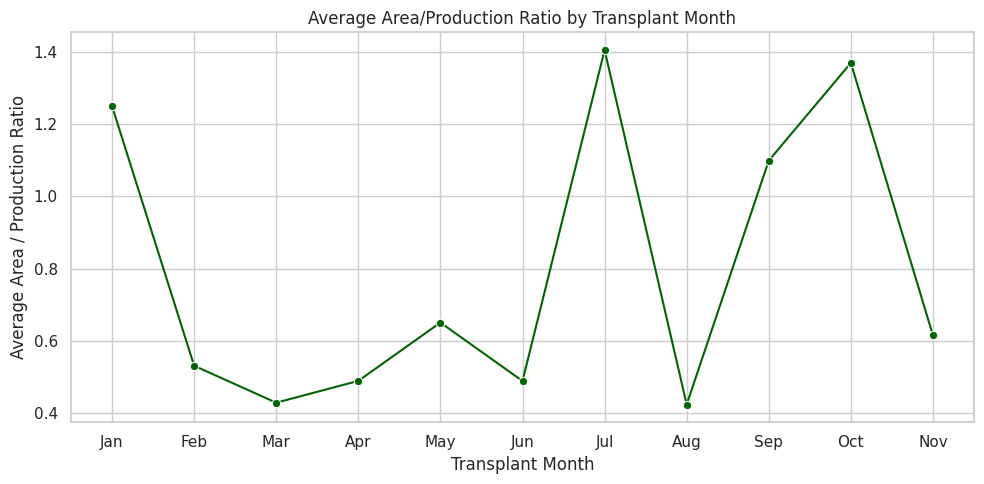

In [ ]:
transplant_eff = df_valid.groupby('transplant_month')['ap_ratio'].mean().reindex(range(1,13))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10,5))
sns.lineplot(x=months, y=transplant_eff.values, marker='o', color='darkgreen')
plt.title('Average Area/Production Ratio by Transplant Month')
plt.ylabel('Average Area / Production Ratio')
plt.xlabel('Transplant Month')
plt.grid(True)
plt.tight_layout()
plt.show()


Insight: The line plot shows fluctuations in the average Area/Production Ratio throughout the year, tied to the transplant month. Months with lower average A/P ratios (dips in the line) suggest periods where crop production is, on average, more efficient in terms of land use. Conversely, months with higher average A/P ratios (peaks in the line) may indicate periods where more land is typically required for the same amount of production. This pattern highlights the seasonal influence on land productivity and could inform optimal transplanting times to maximize output per unit area.

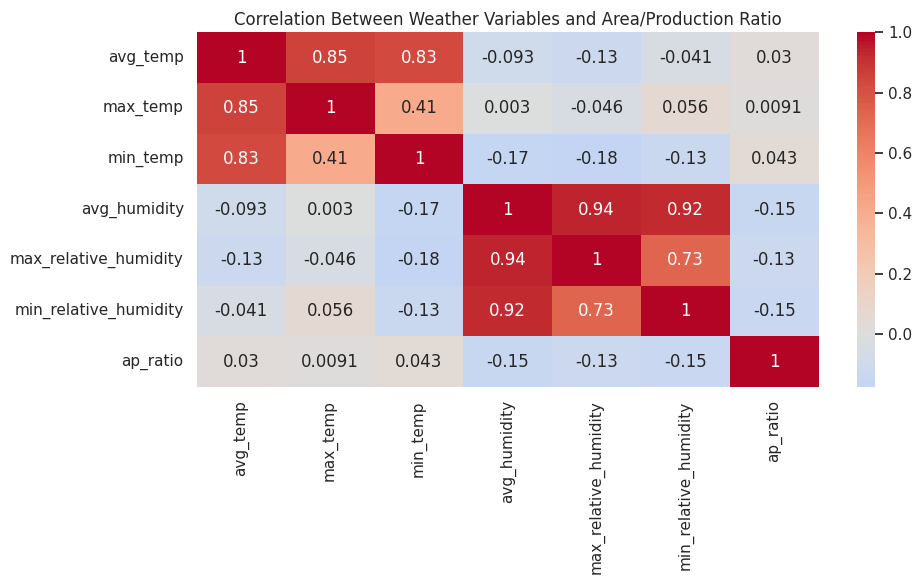

In [ ]:
weather_cols = ['avg_temp', 'max_temp', 'min_temp', 'avg_humidity', 'max_relative_humidity', 'min_relative_humidity']
corr_data = df_valid[weather_cols + ['ap_ratio']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Weather Variables and Area/Production Ratio')
plt.tight_layout()
plt.show()


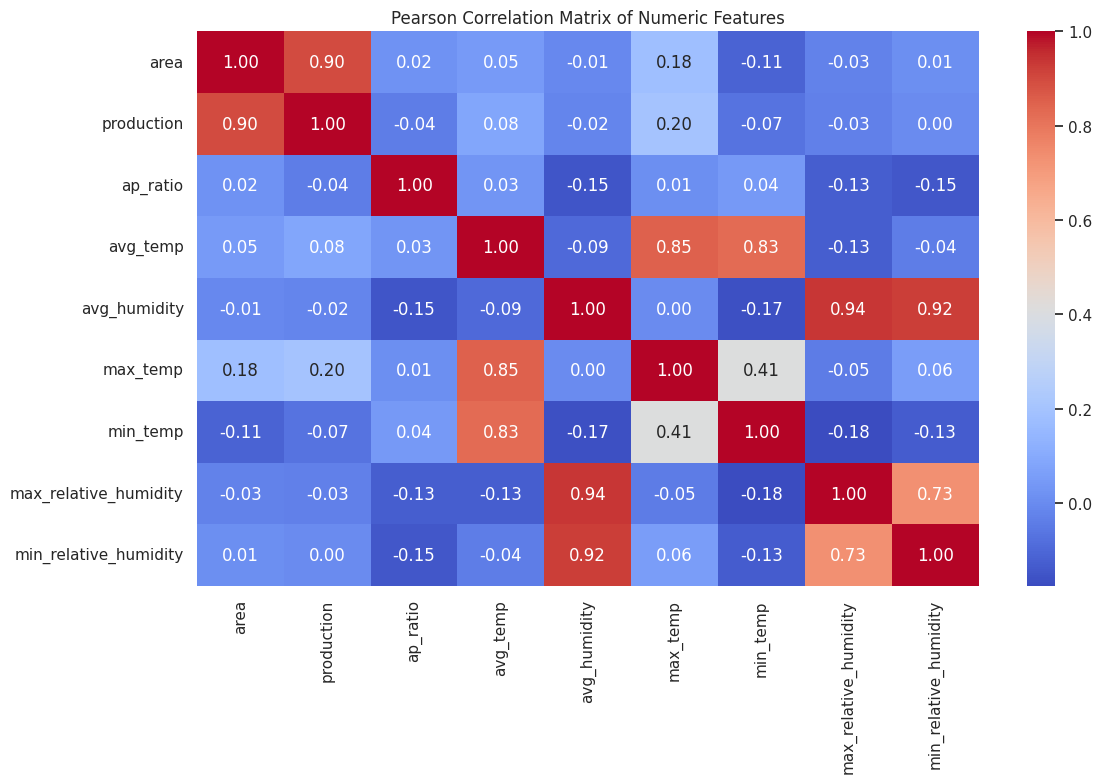

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_valid[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pearson Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()


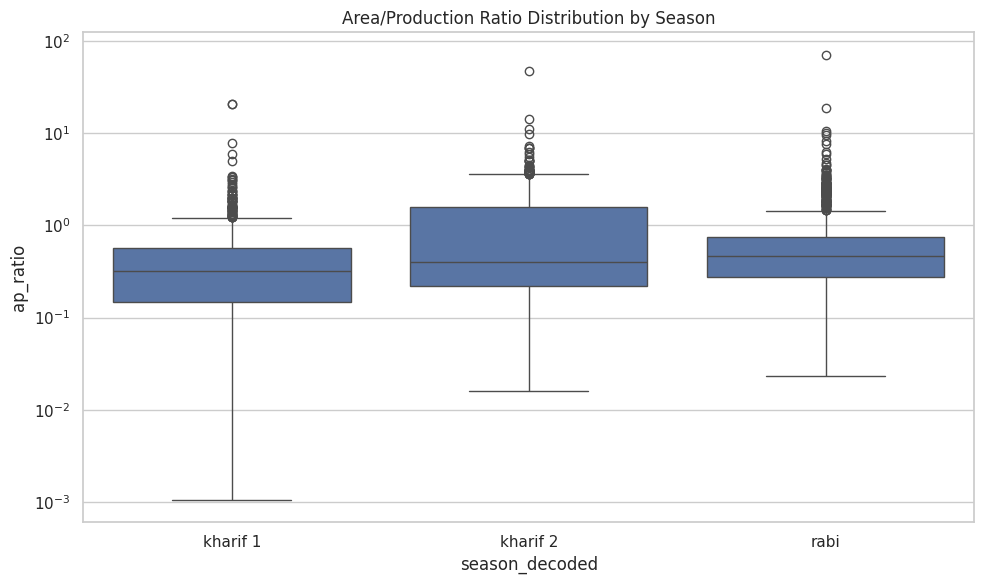

In [ ]:
df_valid['season_decoded'] = le_season.inverse_transform(df_valid['season_enc'].astype(int))

plt.figure(figsize=(10,6))
sns.boxplot(x='season_decoded', y='ap_ratio', data=df_valid)
plt.title('Area/Production Ratio Distribution by Season')
plt.yscale('log')
plt.tight_layout()
plt.show()


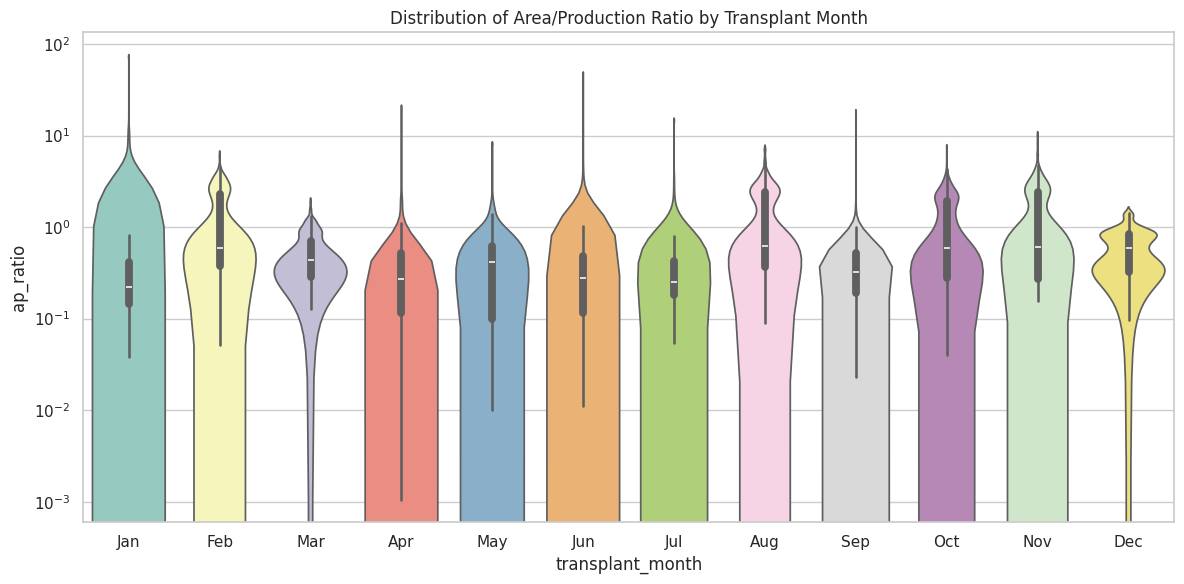

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x='transplant_month', y='ap_ratio', data=df_valid, palette='Set3', hue='transplant_month', legend=False)
plt.title('Distribution of Area/Production Ratio by Transplant Month')
plt.yscale('log')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


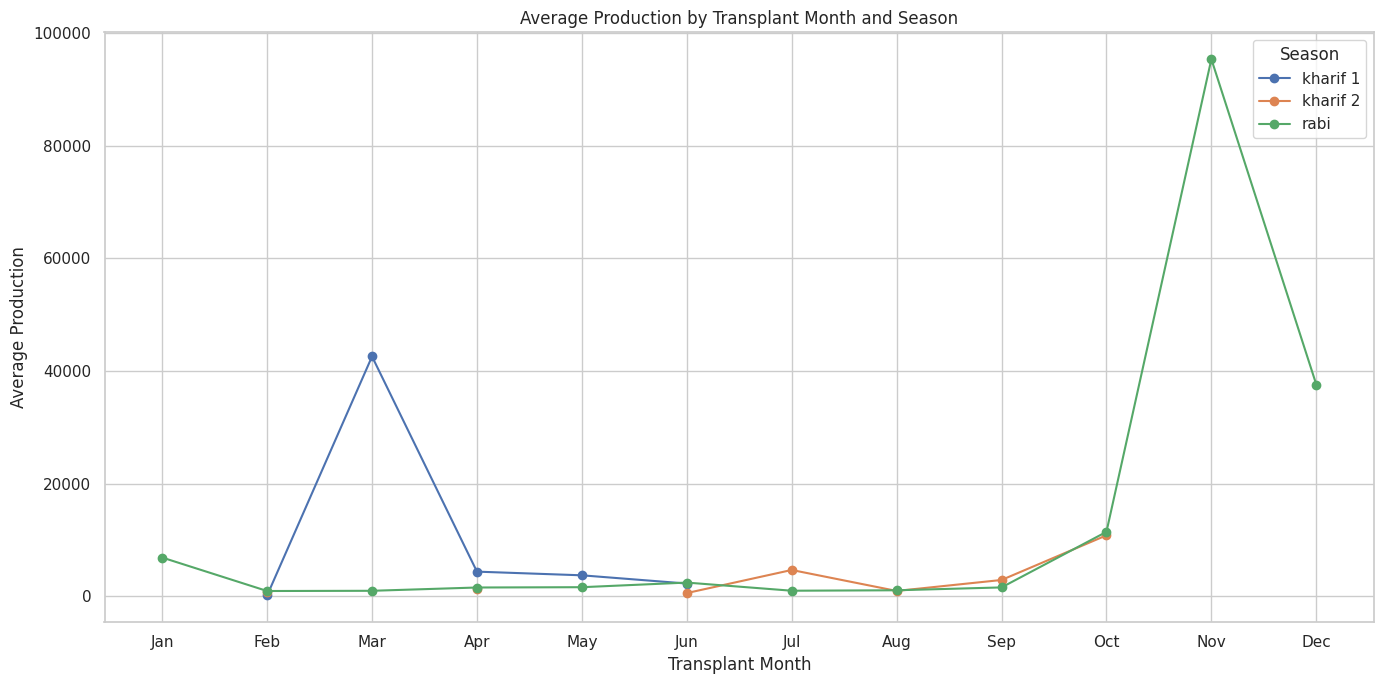

In [ ]:
prod_month_season = df_valid.groupby(['transplant_month', 'season_decoded'])['production'].mean().unstack()

prod_month_season.plot(figsize=(14,7), marker='o')
plt.title('Average Production by Transplant Month and Season')
plt.xlabel('Transplant Month')
plt.ylabel('Average Production')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Season')
plt.tight_layout()
plt.show()


# Feature Engineering

In [ ]:
# Calculating climate risk score

# Compute means and std deviations
mu_T = df_valid[['max_temp', 'min_temp']].stack().mean()
sigma_T = df_valid[['max_temp', 'min_temp']].stack().std()

mu_H = df_valid[['max_relative_humidity', 'min_relative_humidity']].stack().mean()
sigma_H = df_valid[['max_relative_humidity', 'min_relative_humidity']].stack().std()

print(f"mu_T {mu_T}, sigma_T {sigma_T}, mu_H {mu_H}, sigma_H {sigma_H}" )
# Compute Climate Risk Score Index (CRSI)
df_valid['climate_risk_score'] = (
    ((df_valid['max_temp'] - mu_T) / sigma_T) +
    ((df_valid['min_temp'] - mu_T) / sigma_T) +
    ((df_valid['max_relative_humidity'] - mu_H) / sigma_H) +
    ((df_valid['min_relative_humidity'] - mu_H) / sigma_H)
)

# # normalize to 0–1 scale for comparability
# df_valid['climate_risk_score_norm'] = (
#     (df_valid['climate_risk_score'] - df_valid['climate_risk_score'].min()) /
#     (df_valid['climate_risk_score'].max() - df_valid['climate_risk_score'].min())
# )

df_valid[['district_enc', 'climate_risk_score']].head()


mu_T 23.928823243374666, sigma_T 8.823466749085595, mu_H 72.10612691466083, sigma_H 15.203296519844779


,district_enc,climate_risk_score
64,0,-0.03426
65,1,-0.03426
66,2,-0.03426
67,3,-0.03426
68,4,-0.03426


In [ ]:
weather_cols = ['avg_temp', 'avg_humidity', 'max_temp', 'min_temp', 'max_relative_humidity', 'min_relative_humidity']

In [ ]:
df_valid.columns

Index(['area', 'ap_ratio', 'avg_temp', 'avg_humidity', 'production',
       'max_temp', 'min_temp', 'max_relative_humidity',
       'min_relative_humidity', 'growth_jan', 'growth_feb', 'growth_mar',
       'growth_apr', 'growth_may', 'growth_jun', 'growth_jul', 'growth_aug',
       'growth_sep', 'growth_oct', 'growth_nov', 'growth_dec', 'harvest_jan',
       'harvest_feb', 'harvest_mar', 'harvest_apr', 'harvest_may',
       'harvest_jun', 'harvest_jul', 'harvest_aug', 'harvest_sep',
       'harvest_oct', 'harvest_nov', 'harvest_dec', 'crop_name_enc',
       'season_enc', 'district_enc', 'transplant_month', 'crop_name',
       'season_decoded', 'climate_risk_score'],
      dtype='object')

In [ ]:
df_valid.drop(columns=['crop_name', 'season_decoded']+weather_cols, inplace=True)

In [ ]:
# Converting categorical columns data type
cat_cols = ['season_enc', 'district_enc', 'transplant_month', 'crop_name_enc'] \
                                                    + growth_cols + harvest_cols
df_valid[cat_cols] = df_valid[cat_cols].astype('category')

In [ ]:
num_cols = df_valid.select_dtypes(exclude=['category', 'category']).columns
num_cols

Index(['area', 'ap_ratio', 'production', 'climate_risk_score'], dtype='object')

In [ ]:
# Standard scaling
from sklearn.preprocessing import StandardScaler

# Log-transform to reduce skewness
df_valid['area_log'] = np.log1p(df_valid['area'])
df_valid['production_log'] = np.log1p(df_valid['production'])

# Now scale the transformed continuous features
cols_to_scale = ['area_log', 'production_log', 'ap_ratio']  # climate_risk_score is already standardized
scaler = StandardScaler()
df_valid[cols_to_scale] = scaler.fit_transform(df_valid[cols_to_scale])


In [ ]:
df_valid[['area', 'area_log', 'production','production_log']].skew()


,0
area,10.661982
area_log,0.496644
production,9.118331
production_log,0.029147


Skewness has improved after Log transformation

In [ ]:
# Save the label encoders
label_encoders_dict = {
    'district': le_district,
    'season': le_season,
    'crop_name': le_crop
}

joblib.dump(label_encoders_dict, 'label_encoders.joblib')
print("Label encoders saved to label_encoders.joblib")

Label encoders saved to label_encoders.joblib


In [ ]:
# Save the scaler
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved to scaler.joblib")

Scaler saved to scaler.joblib


In [ ]:
df_valid.columns

Index(['area', 'ap_ratio', 'production', 'growth_jan', 'growth_feb',
       'growth_mar', 'growth_apr', 'growth_may', 'growth_jun', 'growth_jul',
       'growth_aug', 'growth_sep', 'growth_oct', 'growth_nov', 'growth_dec',
       'harvest_jan', 'harvest_feb', 'harvest_mar', 'harvest_apr',
       'harvest_may', 'harvest_jun', 'harvest_jul', 'harvest_aug',
       'harvest_sep', 'harvest_oct', 'harvest_nov', 'harvest_dec',
       'crop_name_enc', 'season_enc', 'district_enc', 'transplant_month',
       'climate_risk_score', 'area_log', 'production_log'],
      dtype='object')

## Feature Selection

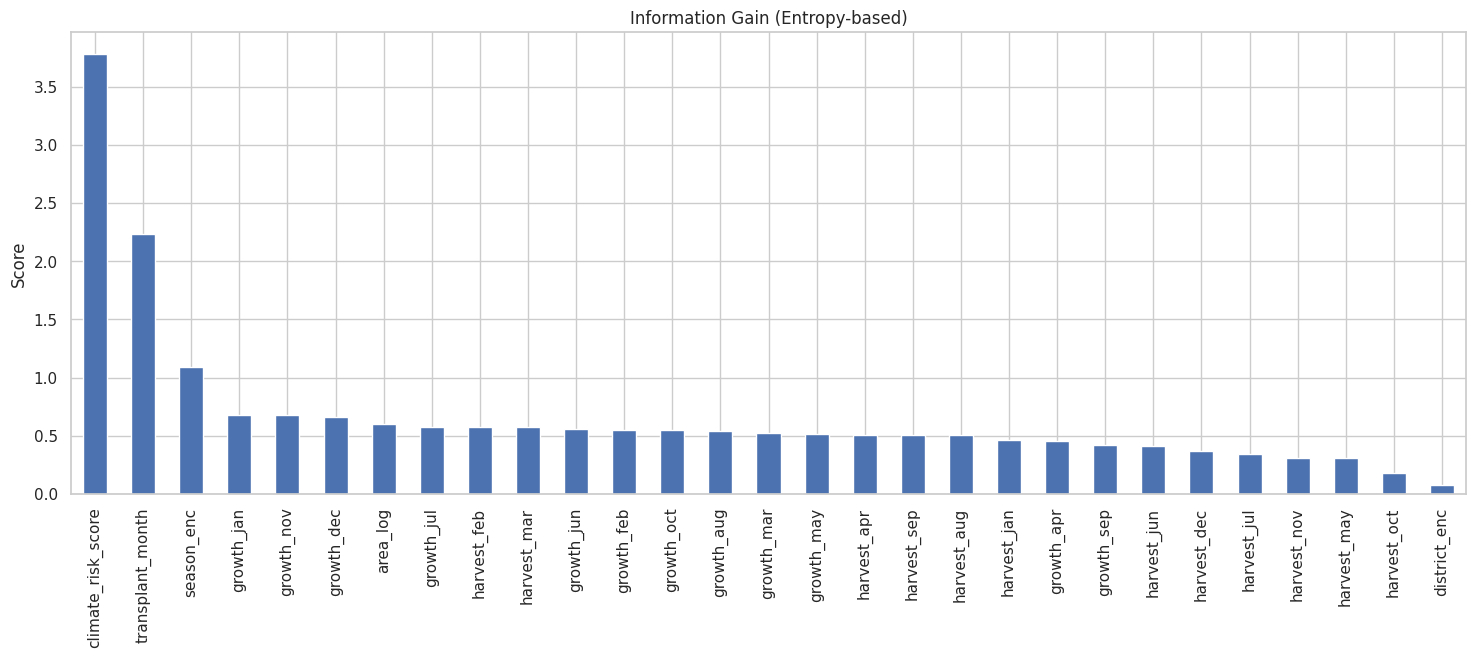

In [ ]:
# Information Gain (Entropy-based)
X = df_valid.drop(columns=['area', 'ap_ratio', 'production', 'crop_name_enc', 'production_log'])
y = df_valid['crop_name_enc']
discrete_mask = X.columns.isin(cat_cols)

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_mask, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# print(mi_scores)
mi_scores.plot(kind='bar', title='Information Gain (Entropy-based)')
plt.ylabel('Score')
plt.show()


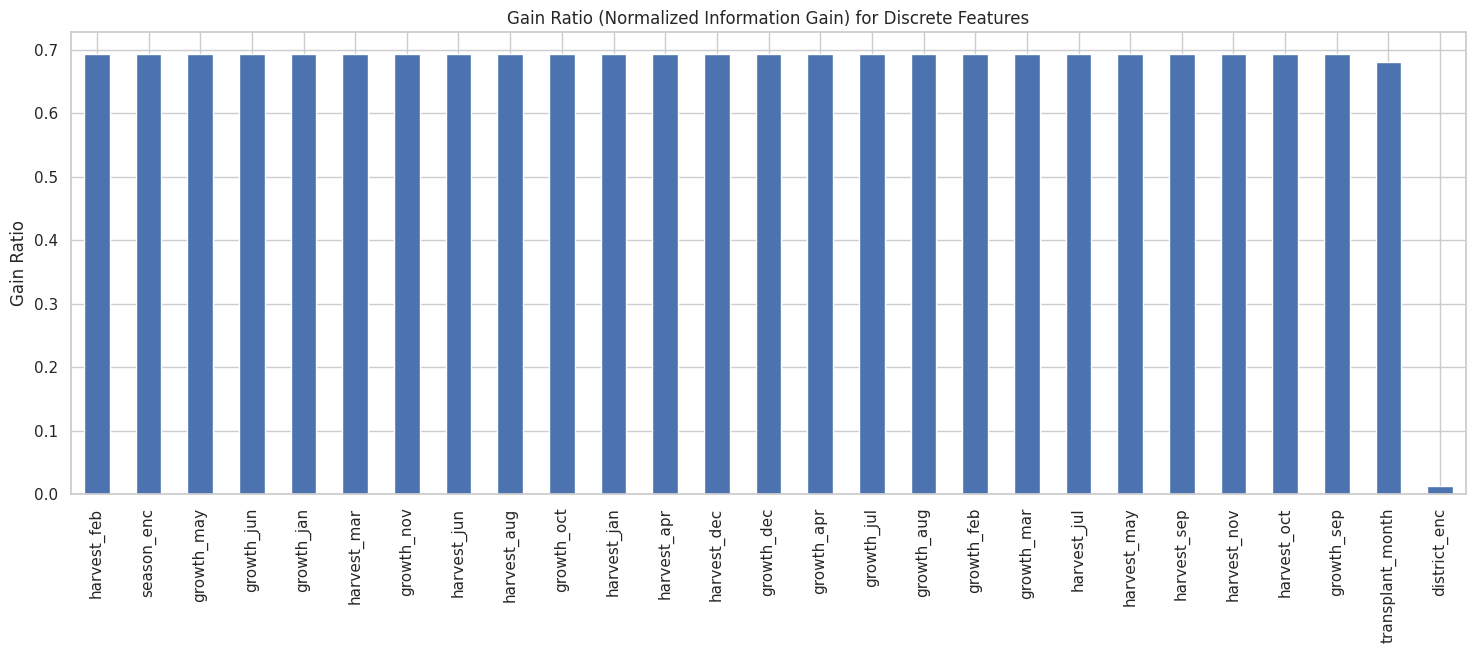

In [ ]:
# Gain Ratio Measuring
def gain_ratio(X, y, discrete_mask):
    ratios = {}
    # Only calculate for discrete features
    for col in X.columns[discrete_mask]:
        ig = mutual_info_score(X[col], y)  # = Information Gain
        h = entropy(pd.Series(X[col]).value_counts(normalize=True), base=2)
        ratios[col] = ig / h if h != 0 else 0
    return pd.Series(ratios).sort_values(ascending=False)

# Use the same discrete_mask created for mutual_info_classif
gain_ratios = gain_ratio(X, y, discrete_mask)

gain_ratios.plot(kind='bar', title='Gain Ratio (Normalized Information Gain) for Discrete Features')
plt.ylabel('Gain Ratio')
plt.show()

In [ ]:
X.columns

Index(['growth_jan', 'growth_feb', 'growth_mar', 'growth_apr', 'growth_may',
       'growth_jun', 'growth_jul', 'growth_aug', 'growth_sep', 'growth_oct',
       'growth_nov', 'growth_dec', 'harvest_jan', 'harvest_feb', 'harvest_mar',
       'harvest_apr', 'harvest_may', 'harvest_jun', 'harvest_jul',
       'harvest_aug', 'harvest_sep', 'harvest_oct', 'harvest_nov',
       'harvest_dec', 'season_enc', 'district_enc', 'transplant_month',
       'climate_risk_score', 'area_log'],
      dtype='object')

In [ ]:
rf_fast = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_fast.fit(X, y)

# --- FASTER SHAP EXPLANATION ---
explainer = shap.TreeExplainer(rf_fast)

# 1. Create a smaller sample of your data (e.g., 1000 rows)
# This is the BIGGEST speed improvement.
X_sample = shap.sample(X, 1000)

# 2. Explain the smaller sample, not the whole dataset 'X'
# This will now run much, much faster.
shap_values = explainer.shap_values(X_sample)

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


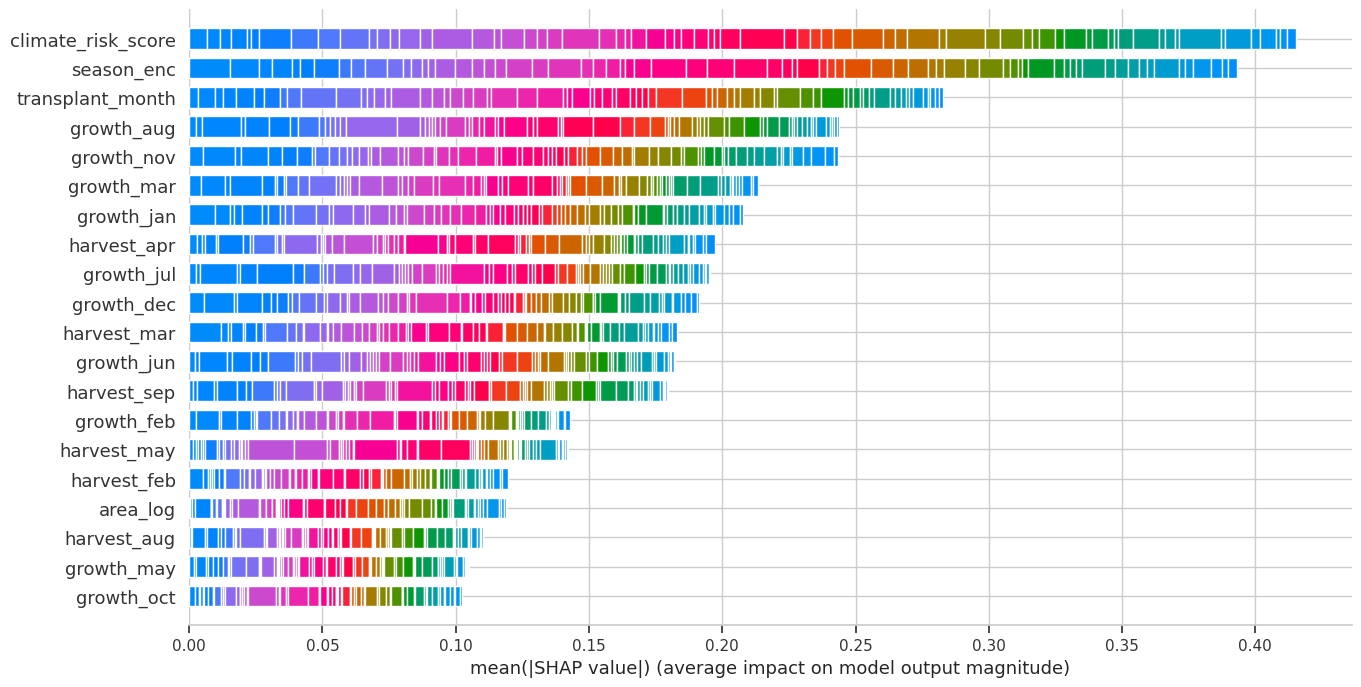

In [ ]:
# Summary plot for overall feature importance
shap.summary_plot(shap_values, X, plot_type="bar", plot_size=(15,8), show=False, color_bar=False)
plt.legend().set_visible(False)
plt.show()


We can see from those explanation plots, only `'district_en'` feature shows less importance, we will not discard it. We want the model to learn that district-crop relationship (that some district restricts some crops)

Based on the plots, the most important features for predicting crop type appear to be:

*   **`climate_risk_score`**: This engineered feature, combining various temperature and humidity measures, shows the highest information gain and strong influence in the SHAP plot. This suggests climate conditions are crucial for determining suitable crops.
*   **Monthly Features (Growth, Harvest, Transplant)**: The one-hot encoded growth and harvest months, along with the transplant month, consistently show high information gain and are significant in the SHAP analysis. This highlights the importance of seasonality and timing in crop selection.
*   **`season_enc`**: The encoded season also demonstrates high information gain, reinforcing the seasonal influence on crop suitability.
*   **`area_log`**: The log-transformed area features have considerable information gain and are important in the SHAP analysis, indicating their relevance in the model.
*   **`district_enc`**: While showing lower information gain compared to others, the district encoding is still present in the SHAP plot, suggesting it contributes to the model's understanding of regional crop patterns, even if less impactful than climate and seasonality.

# Modeling

## Train test split

In [ ]:
X.columns

Index(['growth_jan', 'growth_feb', 'growth_mar', 'growth_apr', 'growth_may',
       'growth_jun', 'growth_jul', 'growth_aug', 'growth_sep', 'growth_oct',
       'growth_nov', 'growth_dec', 'harvest_jan', 'harvest_feb', 'harvest_mar',
       'harvest_apr', 'harvest_may', 'harvest_jun', 'harvest_jul',
       'harvest_aug', 'harvest_sep', 'harvest_oct', 'harvest_nov',
       'harvest_dec', 'season_enc', 'district_enc', 'transplant_month',
       'climate_risk_score', 'area_log'],
      dtype='object')

In [ ]:
# Split data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", xtrain.shape)
print("Shape of X_test:", xtest.shape)

Shape of X_train: (3290, 29)
Shape of X_test: (823, 29)


## Addressing Data Imbalance with SMOTE

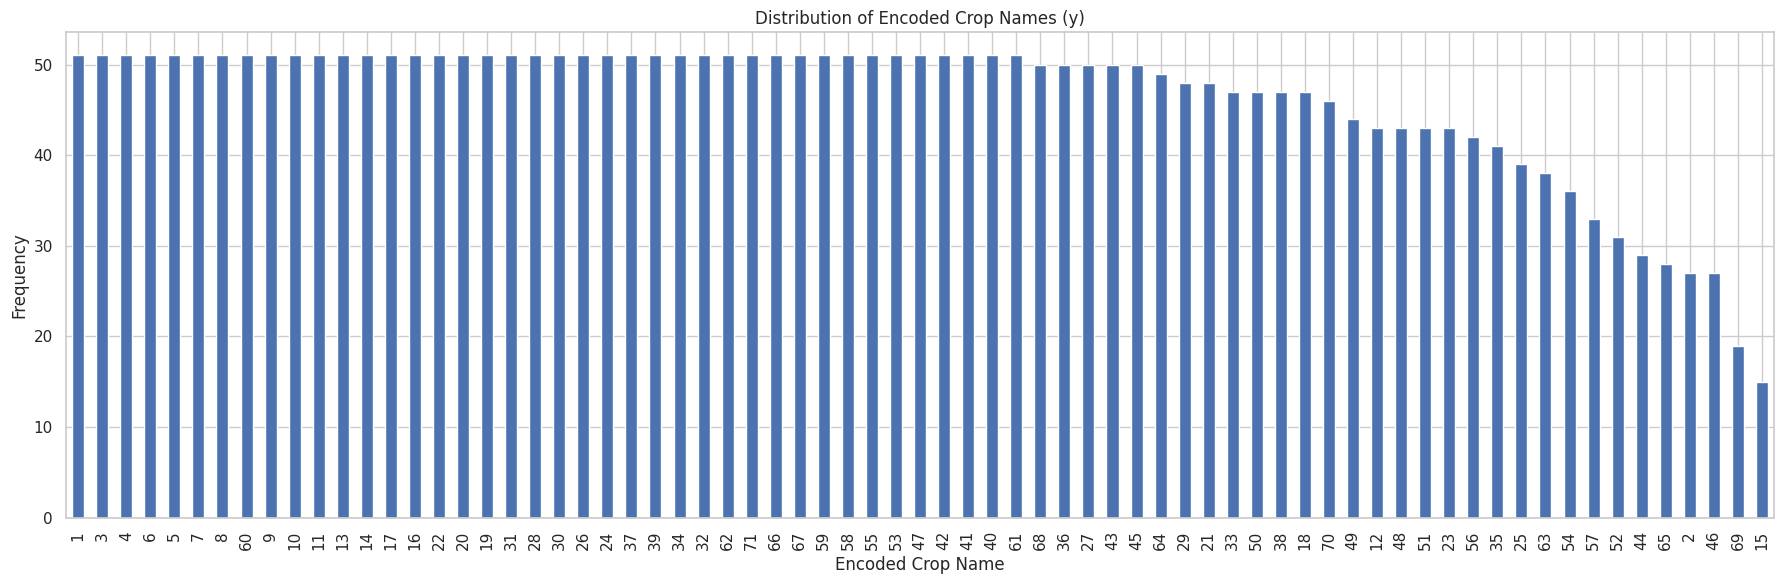

In [ ]:
plt.figure(figsize=(18, 6))
ytrain.value_counts().plot(kind='bar')
plt.title('Distribution of Encoded Crop Names (y)')
plt.xlabel('Encoded Crop Name')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTENC

# Identify categorical features by their indices
# Make sure these indices correspond to the columns in your 'xtrain' DataFrame
categorical_features = xtrain.select_dtypes(include='category').columns.tolist()

# Apply SMOTENC to the training data
smotenc = SMOTENC(categorical_features=categorical_features, random_state=42)
xtrain, ytrain = smotenc.fit_resample(xtrain, ytrain)

print("Shape of X_train_resampled:", xtrain.shape)
print("Shape of y_train_resampled:", ytrain.shape)

Shape of X_train_resampled: (3621, 29)
Shape of y_train_resampled: (3621,)


In [ ]:
# check if SMOTE caused any null values
xtrain.isna().sum().sum()

np.int64(0)

Now let's visualize the distribution of the target variable after applying SMOTE to see how the balance has improved.

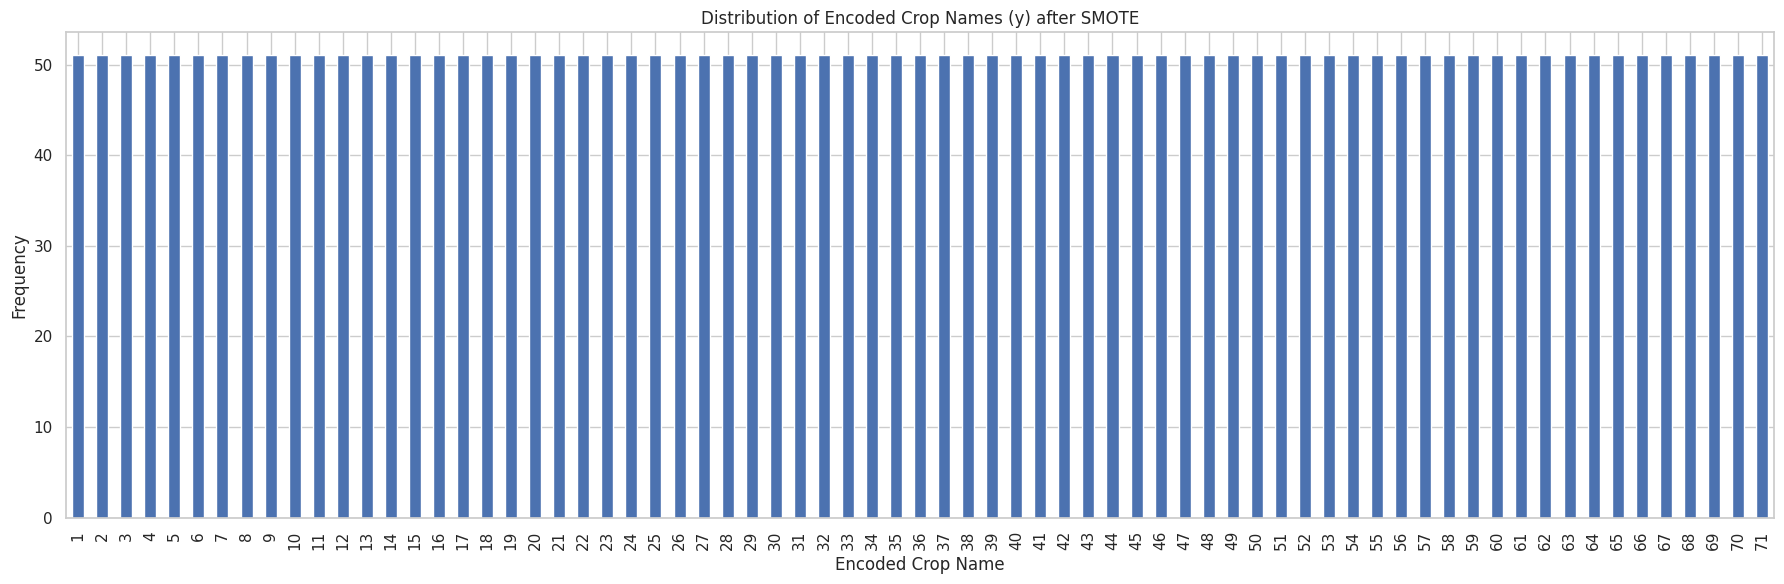

In [ ]:
plt.figure(figsize=(18, 6))
ytrain.value_counts().plot(kind='bar')
plt.title('Distribution of Encoded Crop Names (y) after SMOTE')
plt.xlabel('Encoded Crop Name')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Building models

### Neural Network

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
def preprocess_features(df: pd.DataFrame):
    df = df.copy()

    # --- 1. Binary columns ---
    growth_cols = [c for c in df.columns if c.startswith('growth_')]
    harvest_cols = [c for c in df.columns if c.startswith('harvest_')]
    df[growth_cols + harvest_cols] = df[growth_cols + harvest_cols].astype('int8')

    # --- 2. One-hot encode categorical columns ---
    cat_cols = ['season_enc', 'district_enc', 'transplant_month']
    df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, drop_first=True)
    return df


In [ ]:
xtrain_nn = preprocess_crop_features(xtrain)
xtest_nn = preprocess_crop_features(xtest)
print("Shape of X_train_nn after one-hot encoding:", xtrain_nn.shape)
print("Shape of X_test_nn after one-hot encoding:", xtest_nn.shape)

Shape of X_train_nn after one-hot encoding: (3621, 105)
Shape of X_test_nn after one-hot encoding: (823, 105)


In [ ]:
with open('cols_name.txt', 'w') as f:
    for col in xtrain_nn.columns:
        f.write(f"{col}\n")

In [ ]:
# Ensure target variables are in a suitable numerical format
ytrain = ytrain.astype('int64')
ytest = ytest.astype('int64')

In [ ]:
# Define the neural network model
model = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le_crop.classes_), activation='softmax') # Output layer with softmax for probabilities
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(xtrain_nn, ytrain,
                    epochs=300,
                    batch_size=16,
                    validation_data=(xtest_nn, ytest),
                    callbacks=[early_stopping])

Epoch 1/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.1665 - loss: 3.6637 - val_accuracy: 0.7787 - val_loss: 0.9699
Epoch 2/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6728 - loss: 1.0636 - val_accuracy: 0.8469 - val_loss: 0.4293
Epoch 3/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7730 - loss: 0.6226 - val_accuracy: 0.8852 - val_loss: 0.2805
Epoch 4/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8375 - loss: 0.4340 - val_accuracy: 0.8995 - val_loss: 0.2300
Epoch 5/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8658 - loss: 0.3590 - val_accuracy: 0.9151 - val_loss: 0.1998
Epoch 6/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8750 - loss: 0.3101 - val_accuracy: 0.9127 - val_loss: 0.1865
Epoch 7/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8930 - loss: 0.2710 - val_accuracy: 0.9127 - val_loss: 0.1724
Epoch 8/300
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8983 - loss: 0.2456 - v

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(xtest_nn, ytest)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9118 - loss: 0.1685
Test Loss: 0.1530
Test Accuracy: 0.9127


In [ ]:
perfomance_df = pd.DataFrame(columns=['model', 'train_accuracy', 'test_accuracy'])
perfomance_df.loc[0] = ['NN', history.history['accuracy'][-1], history.history['val_accuracy'][-1]]
perfomance_df

,model,train_accuracy,test_accuracy
0,NN,0.934368,0.909091


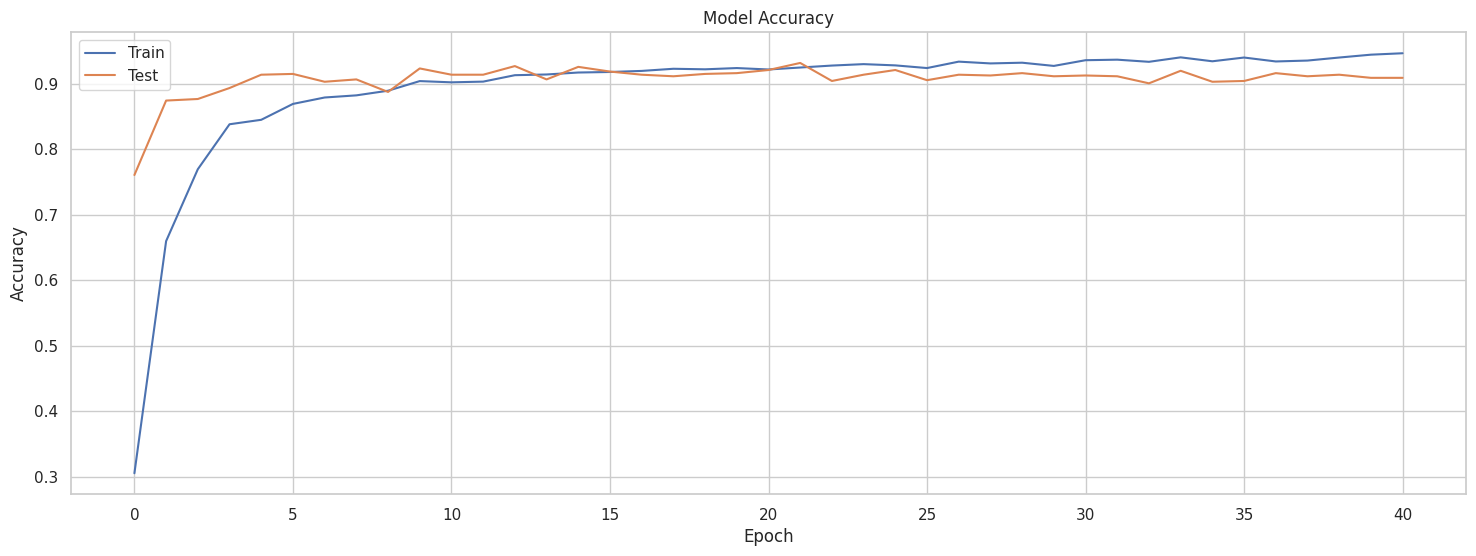

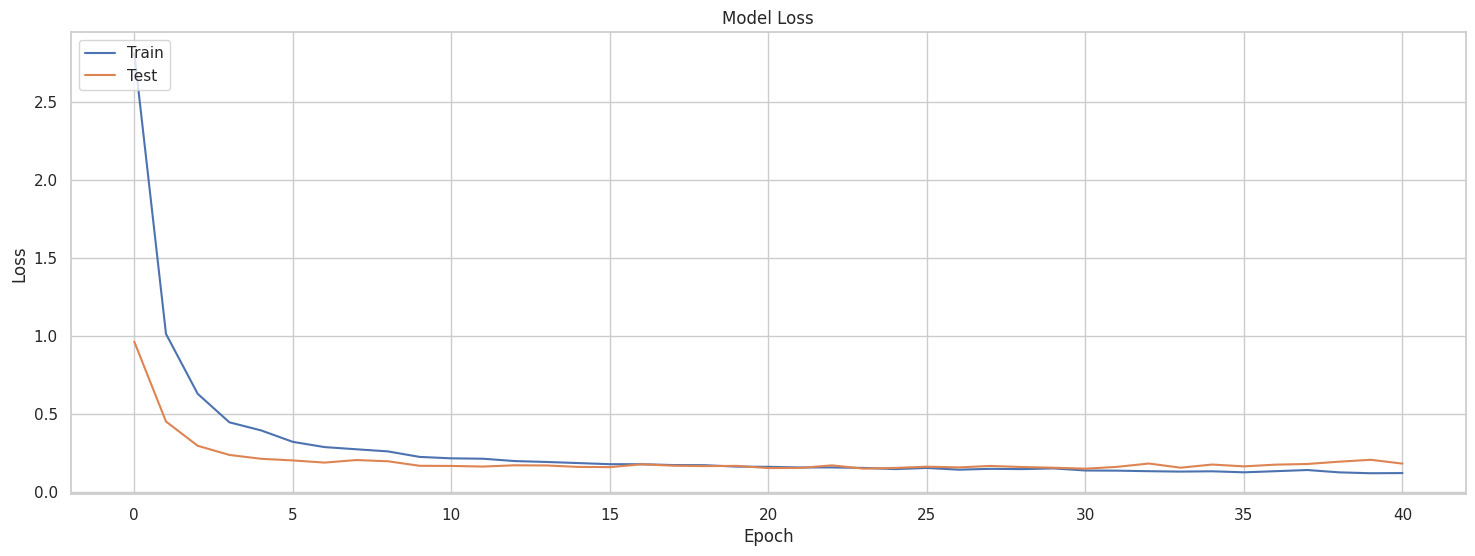

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(18, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(18, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CatBoost

In [ ]:
!pip install -q catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

# Define the categorical features for CatBoost
categorical_features = xtrain.select_dtypes(include='category').columns.to_list()

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000, # Number of boosting iterations
    learning_rate=0.1, # Step size shrinkage
    depth=6, # Depth of the trees
    l2_leaf_reg=3, # L2 regularization term on leaves
    loss_function='MultiClass', # Loss function for multi-class classification
    eval_metric='Accuracy', # Metric to monitor
    random_seed=42, # For reproducibility
    verbose=True, # Set to True to see training progress
    early_stopping_rounds=8 # Stop early if validation metric doesn't improve
)



In [ ]:
# Create CatBoost Pool objects for efficient data handling, specifying categorical features
train_pool = Pool(data=xtrain,
                  label=ytrain,
                  cat_features=categorical_features)

test_pool = Pool(data=xtest,
                 label=ytest,
                 cat_features=categorical_features)


# Train the model
print("Starting CatBoost training...")
catboost_model.fit(train_pool, eval_set=test_pool, use_best_model=True, verbose=True)
print("CatBoost training finished.")

Starting CatBoost training...
0:	learn: 0.2810458	test: 0.2822967	best: 0.2822967 (0)	total: 11.9s	remaining: 3h 18m 38s
1:	learn: 0.4820261	test: 0.4724880	best: 0.4724880 (1)	total: 17.8s	remaining: 2h 28m 10s
2:	learn: 0.6348039	test: 0.6136364	best: 0.6136364 (2)	total: 22.8s	remaining: 2h 6m 17s
3:	learn: 0.7167756	test: 0.7117225	best: 0.7117225 (3)	total: 29.5s	remaining: 2h 2m 25s
4:	learn: 0.7892157	test: 0.7799043	best: 0.7799043 (4)	total: 35.2s	remaining: 1h 56m 35s
5:	learn: 0.8071895	test: 0.7918660	best: 0.7918660 (5)	total: 40.5s	remaining: 1h 51m 56s
6:	learn: 0.8090959	test: 0.7918660	best: 0.7918660 (5)	total: 47s	remaining: 1h 51m 6s
7:	learn: 0.8238017	test: 0.8062201	best: 0.8062201 (7)	total: 53.8s	remaining: 1h 51m 16s
8:	learn: 0.8221678	test: 0.8062201	best: 0.8062201 (7)	total: 59.8s	remaining: 1h 49m 47s
9:	learn: 0.8393246	test: 0.8217703	best: 0.8217703 (9)	total: 1m 5s	remaining: 1h 47m 51s
10:	learn: 0.8398693	test: 0.8217703	best: 0.8217703 (9)	total: 1

In [ ]:
# Save the trained CatBoost model
model_filename = 'catboost_model.cbm'
catboost_model.save_model(model_filename)
print(f"CatBoost model saved to {model_filename}")

CatBoost model saved to catboost_model.cbm


In [ ]:
perfomance_df.loc[1] = ['CB', 0.9422658, 0.9354066986]
perfomance_df

,model,train_accuracy,test_accuracy
0,NN,0.946623,0.909091
1,CB,0.942266,0.935407


### SVM model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize SVM model with RBF kernel and enable probability estimates
svm_model_rbf = SVC(kernel='rbf', random_state=42, probability=True, )

# Train the model
print("Starting SVM (RBF Kernel) training...")
svm_model_rbf.fit(xtrain_nn, ytrain)
print("SVM (RBF Kernel) training finished.")

# Evaluate the model
y_pred_svm_rbf = svm_model_rbf.predict(xtest_nn)

print("\nSVM (RBF Kernel) Classification Report:")
print(classification_report(ytest, y_pred_svm_rbf))

Starting SVM (RBF Kernel) training...
SVM (RBF Kernel) training finished.

SVM (RBF Kernel) Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       0.71      0.77      0.74        13
           3       0.29      0.33      0.31         6
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        13
          16       1

In [ ]:
svm_model_rbf.score(xtrain_nn, ytrain)

0.9379084967320261

In [ ]:
svm_model_rbf.score(xtest_nn, ytest)

0.9258373205741627

In [ ]:
perfomance_df.loc[2] = ['SVM',0.9379084967, 0.92583732]
perfomance_df

,model,train_accuracy,test_accuracy
0,NN,0.946623,0.909091
1,CB,0.942266,0.935407
2,SVM,0.937908,0.925837


### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier
# You can tune these parameters for better performance
# rf_model = RandomForestClassifier(n_estimators=200, # Number of trees in the forest
#                                  max_depth=10,    # Maximum depth of the trees
#                                  min_samples_split=5, # Minimum number of samples required to split an internal node
#                                  min_samples_leaf=3,  # Minimum number of samples required to be at a leaf node
#                                  random_state=42, # For reproducibility
#                                  n_jobs=-1)       # Use all available cores


# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
                           param_grid=param_grid,
                           cv=3, # Number of folds for cross-validation
                           scoring='accuracy', # Metric to optimize
                           n_jobs=-1, # Use all available cores
                           verbose=2) # Print progress messages

# Train the model with GridSearchCV
print("Starting Random Forest Grid Search...")
grid_search.fit(xtrain_nn, ytrain)
print("Random Forest Grid Search finished.")

# Get the best model from GridSearchCV
rf_model = grid_search.best_estimator_

print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate the best model
y_pred_rf = rf_model.predict(xtest_nn)

print("\nRandom Forest Classification Report (Best Model):")
print(classification_report(ytest, y_pred_rf))

Starting Random Forest Grid Search...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest Grid Search finished.

Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Classification Report (Best Model):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       0.71      0.77      0.74        13
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        13


In [ ]:
params = {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
rf_model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
rf_model.fit(xtrain_nn, ytrain)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [ ]:
import joblib

# --- SAVE THE TRAINED MODEL ---
# This is the best model found by GridSearchCV
model_filename = 'random_forest_best_model.joblib'

print(f"\nSaving the best model to {model_filename}...")
joblib.dump(rf_model, model_filename)
print("Model saved successfully!")


Saving the best model to random_forest_best_model.joblib...
Model saved successfully!


In [ ]:
rf_model.score(xtrain_nn, ytrain)

0.947804473902237

In [ ]:
rf_model.score(xtest_nn, ytest)

0.9380315917375456

In [ ]:
perfomance_df.loc[3] = ['RF',0.94662309368, 0.9425837320574]
perfomance_df

,model,train_accuracy,test_accuracy
0,NN,0.946623,0.909091
1,CB,0.942266,0.935407
2,SVM,0.937908,0.925837
3,RF,0.946623,0.942584


# Model Perfomance Comparison

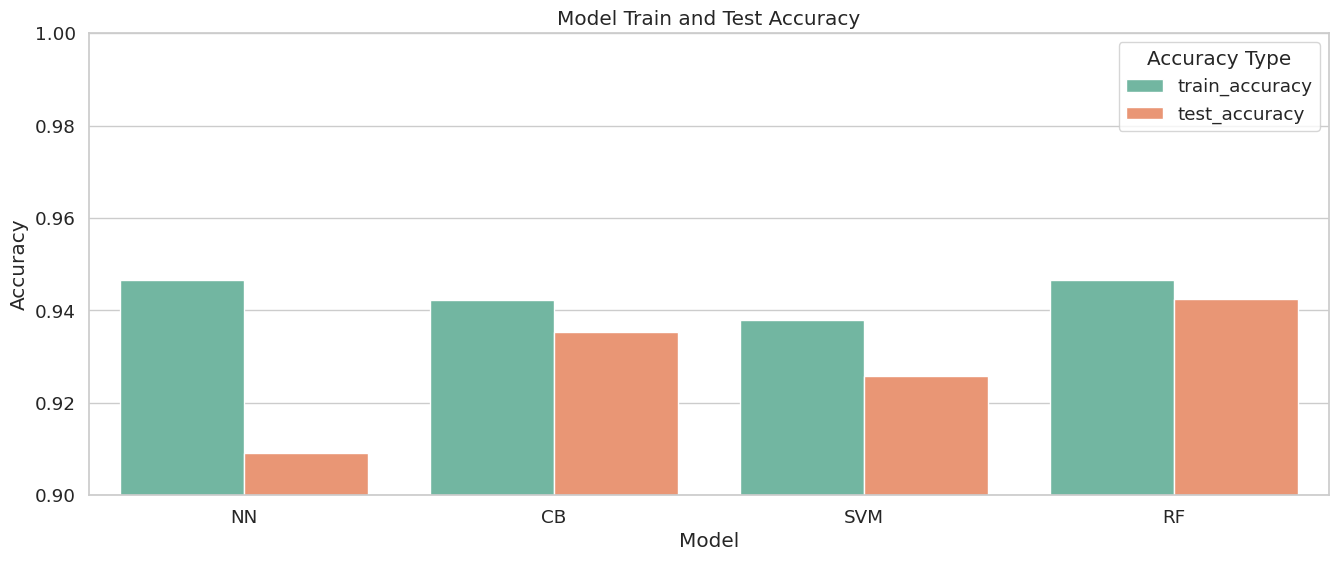

In [ ]:
# Reshape the data for plotting
performance_df_melted = perfomance_df.melt(id_vars='model', var_name='Accuracy Type', value_name='Accuracy')

# Create the plot
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("notebook", font_scale=1.2)
plt.figure(figsize=(16, 6))
sns.barplot(x='model', y='Accuracy', hue='Accuracy Type', data=performance_df_melted)
plt.title('Model Train and Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(title='Accuracy Type')
plt.show()

# Model Evaluation

In [ ]:
import joblib
import pandas as pd
import numpy as np

In [ ]:
def preprocess_pipeline(df: pd.DataFrame, cols_path: str = "cols_name.txt") -> pd.DataFrame:
    df = df.copy()
    with open(cols_path, "r") as f:
        target_cols = [line.strip() for line in f.readlines() if line.strip()]

    growth_cols = [c for c in df.columns if c.startswith('growth_')]
    harvest_cols = [c for c in df.columns if c.startswith('harvest_')]
    df[growth_cols + harvest_cols] = df[growth_cols + harvest_cols].astype('int8')

    cat_onehots = []

    # season_enc (0–3)
    season_onehot = pd.get_dummies(df['season_enc'], prefix='season_enc')
    cat_onehots.append(season_onehot)

    # district_enc (0–63)
    district_onehot = pd.get_dummies(df['district_enc'], prefix='district_enc')
    cat_onehots.append(district_onehot)

    # transplant_month (0–11)
    trans_onehot = pd.get_dummies(df['transplant_month'], prefix='transplant_month')
    cat_onehots.append(trans_onehot)

    # Combine all one-hot blocks
    cat_df = pd.concat(cat_onehots, axis=1)

    # --- 3. Combine everything cleanly ---
    combined_df = pd.concat([
        df[growth_cols + harvest_cols + ['climate_risk_score', 'area_log']],
        cat_df
    ], axis=1)

    # --- 4. Align with training columns ---
    final_df = pd.DataFrame(0, index=np.arange(len(combined_df)), columns=target_cols)
    shared_cols = [c for c in final_df.columns if c in combined_df.columns]
    final_df[shared_cols] = combined_df[shared_cols]

    return final_df


In [ ]:
def data_input_pipeline(user_input, scaler, label_encoders, cols_path:str = "cols_name.txt"):
    import re
    import pandas as pd
    import numpy as np

    features = {}

    district = user_input['district'].strip().lower().title()
    season = user_input['season'].strip().lower()

    if district not in label_encoders['district'].classes_:
        raise ValueError(f"Unknown district: {district}")
    if season not in label_encoders['season'].classes_:
        raise ValueError(f"Unknown season: {season}")


    features['district_enc'] = label_encoders['district'].transform([district])[0]
    features['season_enc'] = label_encoders['season'].transform([season])[0]

    month_abbr_map = {
    'jan': 'january', 'feb': 'february', 'mar': 'march', 'apr': 'april', 'may': 'may',
    'jun': 'june', 'jul': 'july', 'aug': 'august', 'sep': 'september',
    'oct': 'october', 'nov': 'november', 'dec': 'december'
    }

    month_to_idx = {
        'january': 0, 'february': 1, 'march': 2, 'april': 3, 'may': 4, 'june': 5,
        'july': 6, 'august': 7, 'september': 8, 'october': 9, 'november': 10, 'december': 11
    }
    idx_to_month = {v: k for k, v in month_to_idx.items()}

    transplant = user_input['transplant_month'].strip().lower()
    features['transplant_month'] = month_to_idx.get(transplant, -1)
    if features['transplant_month'] == -1:
        raise ValueError(f"Unknown transplant month: {user_input['transplant_month']}")


    def encode_span(span):
        vec = [0]*12
        parts = re.split(r'\s*to\s*', span.strip().lower())
        parts[0] = month_abbr_map.get(parts[0], parts[0])
        parts[1] = month_abbr_map.get(parts[1], parts[1])
        if len(parts) == 2 and parts[0] in month_to_idx and parts[1] in month_to_idx:
            start, end = month_to_idx[parts[0]], month_to_idx[parts[1]]
            if start <= end:
                for i in range(start, end+1): vec[i] = 1
            else:
                for i in range(start, 12): vec[i] = 1
                for i in range(0, end+1): vec[i] = 1
        return vec

    growth_vec = encode_span(user_input['growth_period'])
    for i, m in enumerate(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']):
        features[f'growth_{m}'] = growth_vec[i]

    harvest_vec = encode_span(user_input['harvest_period'])
    for i, m in enumerate(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']):
        features[f'harvest_{m}'] = harvest_vec[i]

    features['area'] = user_input.get('area', 0)

    mu_T = 23.960806606031593
    sigma_T = 8.928376579084118
    mu_H = 72.11165629487793
    sigma_H = 15.164593967354199


    max_temp = user_input.get('max_temp', 0)
    min_temp = user_input.get('min_temp', 0)
    max_relative_humidity = user_input.get('max_relative_humidity', 0)
    min_relative_humidity = user_input.get('min_relative_humidity', 0)


    features['climate_risk_score'] = (
        ((max_temp - mu_T) / sigma_T) +
        ((min_temp - mu_T) / sigma_T) +
        ((max_relative_humidity - mu_H) / sigma_H) +
        ((min_relative_humidity - mu_H) / sigma_H)
    )


    processed_df = pd.DataFrame([features])

    cols_to_scale = ['area']

    processed_df['area_log'] = np.log1p(processed_df['area'])

    processed_df.drop(columns=['area'], inplace=True)


    expected_cols = [
        'growth_jan', 'growth_feb', 'growth_mar', 'growth_apr', 'growth_may',
        'growth_jun', 'growth_jul', 'growth_aug', 'growth_sep', 'growth_oct',
        'growth_nov', 'growth_dec', 'harvest_jan', 'harvest_feb', 'harvest_mar',
        'harvest_apr', 'harvest_may', 'harvest_jun', 'harvest_jul',
        'harvest_aug', 'harvest_sep', 'harvest_oct', 'harvest_nov',
        'harvest_dec', 'season_enc', 'district_enc', 'transplant_month',
        'climate_risk_score', 'area_log'
    ]

    processed_df = processed_df.reindex(columns=expected_cols, fill_value=0)

    for col in processed_df.columns:
        if processed_df[col].dtype == 'category':
            processed_df[col] = processed_df[col].astype(int)

    cols_to_scale_in_pipeline = ['area_log']

    cols_existing_and_to_scale = [col for col in cols_to_scale_in_pipeline if col in processed_df.columns]

    if cols_existing_and_to_scale:
        temp_df_for_scaling = processed_df[cols_existing_and_to_scale].copy()

        scaled_values = scaler.transform(temp_df_for_scaling)

        processed_df[cols_existing_and_to_scale] = scaled_values

    processed_df = preprocess_pipeline(processed_df, cols_path)

    return processed_df

In [ ]:
def predict_crop(model, real_data):
    # predict probability of crops, show top 3
    prediction = model.predict_proba(real_data)
    top_3_indices = prediction[0].argsort()[-3:][::-1]
    top_3_crops = le_crop.inverse_transform(top_3_indices)
    top_3_probabilities = prediction[0][top_3_indices]
    crop_proba = {crop: prob for crop, prob in zip(top_3_crops, top_3_probabilities)}
    return crop_proba

In [ ]:
# Get user input
user_input = {
    'district': input("Enter District: "),
    'season': input("Enter Season (e.g., Kharif 1, Rabi): "),
    'area': float(input("Enter Area (in acres): ")),
    'transplant_month': input("Enter Transplant Month (e.g., June): "),
    'growth_period': input("Enter Growth Period (e.g., jul to oct): "),
    'harvest_period': input("Enter Harvest Period (e.g., Nov to Dec): "),
    'min_temp': float(input("Enter Minimum Temperature (e.g., 20.0): ")),
    'max_temp': float(input("Enter Maximum Temperature (e.g., 40): ")),
    'min_relative_humidity': float(input("Enter Minimum Relative Humidity (e.g., 60): ")),
    'max_relative_humidity': float(input("Enter Maximum Relative Humidity (e.g., 85): ")),
}


scaler = joblib.load('scaler_area.joblib')
label_encoders_dict = joblib.load('label_encoders.joblib')

processed_user_input = data_input_pipeline(user_input, scaler, label_encoders_dict)


Enter District: bogura
Enter Season (e.g., Kharif 1, Rabi): kharif 1
Enter Area (in acres): 14500
Enter Transplant Month (e.g., June): june
Enter Growth Period (e.g., jul to oct): jul to nov
Enter Harvest Period (e.g., Nov to Dec): nov to jan
Enter Minimum Temperature (e.g., 20.0): 20
Enter Maximum Temperature (e.g., 40): 40
Enter Minimum Relative Humidity (e.g., 60): 60
Enter Maximum Relative Humidity (e.g., 85): 85


In [ ]:
model = joblib.load('random_forest_best_model.joblib')
predict_crop(model, processed_user_input)

{'barbati': np.float64(0.41737730952171537),
 'mug': np.float64(0.06924659215186552),
 'maize 2': np.float64(0.04881272797441356)}